In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pygraphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import re
import os
import copy
import pickle
import gzip
import math
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pygraphviz
import datetime
import statistics
from matplotlib_venn import venn3
#stats
from scipy.signal import find_peaks
from itertools import combinations#
from scipy.stats import linregress
date = datetime.datetime.now().strftime("%Y-%m-%d")
to_plot=['A6_v1','COX3', 'CR3', 'CR4', 'CYB','ND3_v1','ND7', 'ND8', 'ND9', 'RPS12']
#from colorspacious import cspace_converter

In [4]:
#####
#output all dictionaries
def pickle_out(var,outfile):
    out,errors,names=[],[],[]
    with gzip.open('tmp', 'wb') as f:
        for k in var:
            if type(var[k]) is dict and not k.startswith('_'):
                try:
                    pickle.dump(var[k], f)
                    out.append(var[k])
                    names.append(k)
                    print(f'dump {k}')
                except:
                    errors.append(f"{k} failed")
    print(errors)
    f.close()
    names.append('save')
    out.append(names)
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(out, f)
    f.close()
    print(len(out))
    
def pickle_load(file,prefix):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    print([f"{prefix}_{i}"  for i in out[-1]])
    return out
##

#####
def get_gRNA_info (txt,adjust=0): #build dictionary from gRNA_with_expression files
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{i}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for i,line in enumerate(handle)}
        for key in gRNA_dict:
            init_site=int(gRNA_dict[key]['mRNA_end'])+int(gRNA_dict[key]['rel_pos'])
            if gRNA_dict[key]['mRNA_name'] not in ['CYB','MURF2']:
                gRNA_dict[key]['gene_mRNA_end']=init_site+adjust
            else:
                gRNA_dict[key]['gene_mRNA_end']=init_site
    return(gRNA_dict)  
#get deletion and editing seuqences
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
#initiation site counts
def initiation_site_counts(gRNA_dict,small_u):
    insertions=read_editing_sites(small_u)
    mrna0={k:[0]*(len(insertions[k])+100) for k in insertions} #extend the mRNA a bit longer for the initiation sites
    anchors={k:[0]*(len(insertions[k])+100) for k in insertions}
    fullanc={k:[0]*(len(insertions[k])+100) for k in insertions}
    for k in gRNA_dict:
        if gRNA_dict[k]['mRNA_name'] in ['ND8_PacBio','CYB_short']:
            continue
        else:
            init_site=gRNA_dict[k]['gene_mRNA_end']
            anc=int(gRNA_dict[k]['mRNA_end'])-max((int(gRNA_dict[k]['anchor_len']),6))
            mrna0[gRNA_dict[k]['mRNA_name']][init_site]+=1
            anchors[gRNA_dict[k]['mRNA_name']][anc]+=1
            for i in range(anc,int(gRNA_dict[k]['mRNA_end'])):
                fullanc[gRNA_dict[k]['mRNA_name']][i]+=1
    return(mrna0,anchors,fullanc)
#visualize the features
def slide_window_plot(inits,anchors,filename,ws=1,figw=100,figh=50):
    counts={k:[sum(inits[k][i:i+ws]) for i in range(len(inits[k])-ws)] for k in inits} #find initiation sites with window
    counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
    return(counts,counts_a)
def slide_window_plot_by_strain(strain_grna,small_u,insertions,file1,file2,ws=1,figw=100,figh=50):
    taxon_dict={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue','EATRO1125':'orange'}
    fig,axs = plt.subplots(len(insertions),1,figsize=(figw,figh))
    for s in strain_grna:
        inits,anchors,fullanc=initiation_site_counts(strain_grna[s],small_u)
        counts={k:[sum(inits[k][i:i+ws]) for i in range(len(inits[k])-ws)] for k in inits} #find initiation sites with window
        counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
        c=0
        for k in insertions:
            ax=axs[c]
            ax.set_title(f'anchor starts/full-length anchor coverage on {k}, window size= {ws}',fontdict={'fontsize': 30, 'fontweight': 30})
            c+=1
            #plot init sites
            ax.plot(range(len(counts[k])),counts[k],label=s,color=taxon_dict[s])
            #plot anchors
            ax.plot(range(len(counts_a[k])),np.array(counts_a[k])*(-1),color=taxon_dict[s])
    plt.legend()
    plt.savefig(file1)
    #plt.show()
    #draw full length anchors
    fig,axs = plt.subplots(len(insertions),1,figsize=(figw,figh))
    sum_anchor={k:np.array([0]*(len(counts[k])+1)) for k in counts_a}
    for s in strain_grna:
        inits,anchors,fullanc=initiation_site_counts(strain_grna[s],small_u)
        sum_anchor={k:sum_anchor[k]+np.array(v) for k,v in fullanc.items()}
        counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
        c=0
        for k in insertions:
            ax=axs[c]
            ax.set_title(f'Initiation sites/anchor starts on {k}, window size= {ws}',fontdict={'fontsize': 30, 'fontweight': 30})
            c+=1
            #plot init sites
            ax.plot(range(len(counts_a[k])),counts_a[k],label=s,color=taxon_dict[s],alpha=0.4)
            #plot anchors
            ax.plot(range(len(fullanc[k])),np.array(fullanc[k])*(-1),color=taxon_dict[s],alpha=0.4)
    for i,k in enumerate(insertions):
        ax=axs[i]
        ax.plot(range(len(sum_anchor[k])),np.array(sum_anchor[k])*(-1),label='SUM',color='k',alpha=0.4)
    plt.legend()
    plt.savefig(file2)
    plt.show()
    return(sum_anchor)
#define gRNA family boundaries
def anchor_clusters(counts):
    gRNA_families={}
    for k in counts:
        #find boundaries
        mrna=''.join([str(9) if i >9 else str(i) for i in counts[k]]) #one digit only real number count has 10 and can cause trouble
        starts=[match.start() for match in re.finditer('0{1,}',mrna)] #change from 3 to 1
        ends=[match.end() for match in re.finditer('0{1,}',mrna)]
        boundaries=[(i,j) for i,j in zip(ends[:-1],starts[1:])]
        gRNA_families[k]={f'{k}-{pair[0]}_{pair[1]}':{'bound':pair,'gRNA':[],'mRNA':k,'coverage':mrna[pair[0]:pair[1]]} for i,pair in enumerate(boundaries)}#','.join([str(i) for i in counts[k][pair[0]:pair[1]]])
        gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
        #print(gRNA_families)     
    total=sum([len(v) for v in gRNA_families.values()])
    print(f"identified {total} anchor clusters")
    return(gRNA_families)
#subdivision
def subdivision(gRNA_families,mrna,k,ds):#ds are pieces of the coverage string
    bound=gRNA_families[mrna][k]['bound']
    for d in ds:
        start=re.search(d,gRNA_families[mrna][k]['coverage']).start()+gRNA_families[mrna][k]['bound'][0]
        end=start+len(d)
        name=f"{mrna}-{start}_{end}"
        gRNA_families[mrna][name]={'bound':(start,end),'gRNA':[],'mRNA':mrna,'coverage':d}
        print(gRNA_families[mrna][name])
    gRNA_families[mrna].pop(k)
#assign gRNA families
#
def assign_gRNA_families_anchor(gRNA_dict,gRNA_families,to_plot=to_plot):
    for k in gRNA_dict:
        gRNA_dict[k]['gRNA_family']=[]
        hit=0
        if gRNA_dict[k]['mRNA_name'] in to_plot:
            for f in gRNA_families[gRNA_dict[k]['mRNA_name']]:
                bound=gRNA_families[gRNA_dict[k]['mRNA_name']][f]['bound']
                if int(gRNA_dict[k]['mRNA_end']) >= bound[0] and int(gRNA_dict[k]['mRNA_end']) <= bound[1]:
                    gRNA_dict[k]['gRNA_family'].append(f)
                    gRNA_families[gRNA_dict[k]['mRNA_name']][f]['gRNA'].append(k)
                    hit+=1
                    break
            if hit==0:
                print(f'error:cannot assign family for {k}')
                print(gRNA_dict[k])
    return(gRNA_dict,gRNA_families)
#character minicircles by gRNA family
def assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families): #use the new version
    mini_dict,cassettes,non_cannonical={},['I','II','III','Orphan'],[]
    for g in gRNA_dict:
        if gRNA_dict[g]['mO_name'] not in mini_dict:
            mini_dict[gRNA_dict[g]['mO_name']]={c:{} for c in cassettes}
            mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']]=gRNA_dict[g]
        else:
            mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']]=gRNA_dict[g]
    mini_dict.pop('Maxicircle','None') #remove maxicircle      
    mini_df = pd.DataFrame(columns=cassettes,index=mini_dict.keys())
    for mini in mini_dict:
        for c in mini_dict[mini]:
            try:
                mini_df.loc[[mini],[c]]=mini_dict[mini][c]['gRNA_family'][0]
            except:
                non_cannonical.append(f"no cannonical gRNA found in cassette {c} in minicircle {mini}")
    mini_df=mini_df.sort_values(by=cassettes)
    return(mini_dict,mini_df)
def make_minicircle_family(mini_dict):
    mini_families={}
    for mini in mini_dict:
        hit=0
        #create a unique descriptor for each minicircle
        try:
            cs=';'.join([mini_dict[mini][c].get('gRNA_family','n')[0] for c in mini_dict[mini]])
            if cs not in mini_families:
                mini_families[cs]=[]
                mini_families[cs].append(mini)
            else:
                mini_families[cs].append(mini)
        except:
            print(f'error for {mini} {mini_dict[mini]}')
    #sort by the number of encoded gRNAs
    tmp={k:k.count('n') for k in mini_families}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_families={k:mini_families[k] for k in ordered}
    return(mini_families)

#gRNA family and minicircle family stats
def gRNA_family_stats(gRNA_dict,gRNA_families, figw=25,figh=50): #use the new version
    #presence in multiple cassettes
    x,y,z=[],[],[]
    fig,axs = plt.subplots(2,3,figsize=(figw,figh))
    for k in gRNA_families:
        for f in gRNA_families[k]:
            y.append(len(gRNA_families[k][f]['gRNA']))
            z.append(len(set([gRNA_dict[g]['mO_name'] for g in gRNA_families[k][f]['gRNA']])))
            cst={}
            for g in gRNA_families[k][f]['gRNA']:
                l=gRNA_dict[g]['cassette_label']
                if l not in cst:
                    cst[l]=1
                else:
                    cst[l]+=1
            gRNA_families[k][f]['cassettes']=cst
            x.append(len(cst))
            #if len(cst)>1:
                #print(k,cst)
    ax=axs[0,0]
    ax.hist(x,bins=np.array(range(0,(max(x)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in number of different cassettes')
    ax.set_ylabel('number of gRNA family')
    #how many gRNAs are in one gRNA fam
    ax=axs[0,1]
    ax.hist(y,bins=np.array(range(0,(max(y)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('number of gRNAs in each gRNA family')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles contain the same gRNA family
    ax=axs[0,2]
    ax.hist(z,bins=np.array(range(0,(max(z)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles families contain the same gRNA family
    ax=axs[1,0]
    mf=[len(gRNA_families[k][gf].get('minicircle_family','n')) for k in gRNA_families for gf in gRNA_families[k]]
    ax.hist(mf,bins=np.array(range(0,(max(mf)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles families')
    ax.set_ylabel('number of gRNA family')
    #length distribution of gRNA families (boundary length)
    gflen=[((gRNA_families[k][gf]['bound'][1]-gRNA_families[k][gf]['bound'][0]),len(gRNA_families[k][gf]['cassettes'])) for k in gRNA_families for gf in gRNA_families[k]]
    len_c={i+1:{c:0 for c in [1,2,3,4,5,6]} for i in range(0,(max([i[0] for i in gflen])+1),1)}
    for boundary in gflen:
            for k in len_c:
                if boundary[0]==k:
                    len_c[k][boundary[1]]+=1
    ax=axs[1,1]
    ax.hist([i[0] for i in gflen],bins=np.array(range(0,(max([i[0] for i in gflen])+1),1))) #np array can be used as a vector
    ax.set_xlabel('length of initiation site boundaries')
    ax.set_ylabel('number of gRNA family')
    ax=axs[1,2]
    df=pd.DataFrame.from_dict(len_c,orient='index')
    ax.bar(df.index, (df[1]), label='1',color='blue')
    ax.bar(df.index, (df[2]),bottom=(df[1]),label='2',color='cornflowerblue')
    ax.bar(df.index, (df[3]),bottom=(df[1]+df[2]),label='3',color='dodgerblue')
    ax.bar(df.index, (df[4]),bottom=(df[1]+df[2]+df[3]),label='4',color='steelblue')
    ax.bar(df.index, (df[5]),bottom=(df[1]+df[2]+df[3]+df[4]),label='5',color='skyblue')
    ax.bar(df.index, (df[6]),bottom=(df[1]+df[2]+df[3]+df[4]+df[5]),label='6',color='lightcoral')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    ax.set_xlabel('initiation site boundary length')
    ax.set_ylabel('number of gRNA families')
    #another figure
    fig,axs = plt.subplots(2,1,figsize=(figw,figh))
    #number of gRNA families for each mRNA,seperated by cassettes
    g_f=[len(gRNA_families[k]) for k in gRNA_families] 
    mrna=[k for k in gRNA_families]
    ax=axs[0]
    ax.bar(mrna,g_f)
    #number of gRNA for each mRNA,seperated by cassettes
    mrna_cst,cassettes={},['I','II','III','IV','V','Orphan']
    for k in gRNA_families:
        mrna_cst[k]={c:0 for c in cassettes}
        for f in gRNA_families[k]:
            for g in gRNA_families[k][f]['gRNA']:
                if gRNA_dict[g]['cassette_label'] in mrna_cst[k]:
                    mrna_cst[k][gRNA_dict[g]['cassette_label']]+=1
    df=pd.DataFrame.from_dict(mrna_cst,orient='index')
    print(df)
    ax=axs[1]
    ax.bar(df.index, (df['I']), label='I',color='blue')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='cornflowerblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='dodgerblue')
    ax.bar(df.index, (df['IV']),bottom=(df['I']+df['II']+df['III']),label='IV',color='steelblue')
    ax.bar(df.index, (df['V']),bottom=(df['I']+df['II']+df['III']+df['IV']),label='V',color='skyblue')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']+df['IV']+df['V']),label='Orphan',color='lightcoral')
    ax.set_xlabel('mRNAs')
    ax.set_ylabel('number of gRNA')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    plt.show()

#list gRNA families of interest
def output_gRNA_families(gRNA_families2,gRNA_dict,threshold=6):
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}
    #gRNA families that present in multiple cassettes
    multi={gf:len(grna_families[gf]['cassettes']) for gf in grna_families if len(grna_families[gf]['cassettes'])>1}
    multi={k: v for k, v in sorted(multi.items(), key=lambda item: item[1])}
    print(f"gRNA families detected in multiple cassettes:\n{multi}")
    #gRNA families that are present in the most minicircles
    many={gf:len(grna_families[gf]['gRNA']) for gf in grna_families if len(grna_families[gf]['gRNA'])>=threshold}
    many={k: v for k, v in sorted(many.items(), key=lambda item: item[1])}
    print(f"gRNA families present in more than {threshold} minicircles:\n{many}")
            
#combine the same gRNA in v1 v2
def combine_alternatives(gRNA_dict):
    alt,paired={},[]
    other={g:gRNA_dict[g] for g in gRNA_dict if '_v' not in gRNA_dict[g]['mRNA_name']}
    v1={g:gRNA_dict[g] for g in gRNA_dict if '_v1' in gRNA_dict[g]['mRNA_name']}
    v2={g:gRNA_dict[g] for g in gRNA_dict if '_v2' in gRNA_dict[g]['mRNA_name']}
    print('number of gRNAs for v1 and v2 mRNAs',len(v1),len(v2))
    for g1 in v1:
        for g2 in v2:
            if v1[g1]['mO_name']==v2[g2]['mO_name'] and v1[g1]['cassette_label']==v2[g2]['cassette_label'] and v1[g1]['product']==v2[g2]['product']:
                dcs=int(v1[g1]['circle_start'])-int(v2[g2]['circle_start'])
                dce=int(v1[g1]['circle_end'])-int(v2[g2]['circle_end'])
                if dcs>2 or dce>2:
                    #this is just for manual checking
                    print('paired gRNA with >2bp difference on minicircle:',v1[g1]['name'],v2[g2]['name'])
                paired.append(g2)
                alt[g1]=g2
    v2={k:v2[k] for k in v2 if k not in paired}
    uv2={k:v for k,v in v2.items() if k not in alt.values()}
    uv1={k:v for k,v in v1.items() if k not in alt.keys()}
    print('number of gRNAs only in v1 or in v2',len(uv1),len(uv2))
    print('\ndistinct gRNAs for alternatively edited mRNAs:')
    for k in v2:
        print(v2[k]['name'])
    v1.update(v2) #old
    v1.update(other) #old
    print(f"number of gRNAs after removing repetitive ones for different versions: {len(v1)}")
    shared={k.replace('_v1',''):v for k,v in v1.items() if k in alt.keys()}
    shared.update(uv1)
    shared.update(uv2)
    shared.update(other)
    return(v1) #old

#visualization and validation of gRNA families
def gRNA_family_validation(gRNA_dict2,gRNA_families2,filename,figw=50,figh=50,floor=-20):
    c=0
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(gRNA_families2),1,figsize=(figw,figh))
    for k in gRNA_families2:
        ax,d=axs[c],0
        c+=1
        ax.set_title(f'distribution of gRNA families on {k}',fontdict={'fontsize': figh/5, 'fontweight': figh/5})
        ax.set_xlim(left=0,right=len(insertions[k]))
        #ax.set_xlim(len(insertions[k])) #can flip x_axis
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #ax.text(-10,0,"insertions",fontsize=25)
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #ax.text(-10,-1,"deletions",fontsize=25)
        #draw gRNA families
        ceiling=d
        for gf in gRNA_families2[k]:
            #ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{k} init range: {gRNA_families2[k][gf]['bound']}")
            ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{gf}")
            for g in gRNA_families2[k][gf]['gRNA']:
                ms=int(gRNA_dict2[g]['mRNA_start'])
                me=int(gRNA_dict2[g]['mRNA_end'])
                al=int(gRNA_dict2[g]['anchor_len'])
                ie=int(gRNA_dict2[g]['gene_mRNA_end'])
                ax.add_patch(Rectangle((ms, d), me-al-ms, -1,
                                  facecolor = 'black',alpha=0.1)) #coding region
                ax.add_patch(Rectangle((me-al, d), al, -1,
                                  facecolor = 'red',alpha=0.1)) #anchor
                ax.add_patch(Rectangle((me, d), ie-me, -1,
                                  facecolor = 'blue',alpha=0.1)) #init sequence
            d+=-2
            if d <floor:
                d=ceiling
    plt.savefig(filename)
    plt.show()
#manually combine gRNA families based on gRNA family distribution
def manual_merge_gRNA_fam(gRNA_families2, clusters=[[]]):
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}#change the structure for convenience
    print('total gRNA family: ',len(grna_families))
    for cluster in clusters:
        lower_bound,upper_bound,gRNA,cassettes=[],[],[],{}
        try:
            for gf in cluster:
                mrna=grna_families[gf]['mRNA']
                lower_bound.append(grna_families[gf]['bound'][0])
                upper_bound.append(grna_families[gf]['bound'][1])
                gRNA+=grna_families[gf]['gRNA']
                for c in grna_families[gf]['cassettes']:
                    if c in cassettes:
                        cassettes[c]+=grna_families[gf]['cassettes'][c]
                    else:
                        cassettes[c]=grna_families[gf]['cassettes'][c]
                grna_families.pop(gf)
            grna_families[f'{mrna}-{min(lower_bound)}_{max(upper_bound)}']={'bound':(min(lower_bound),max(upper_bound)),
                                                                    'gRNA':gRNA,'mRNA':mrna,'cassettes':cassettes}
        except:
            print(f"{cluster} already merged")
    print('after merging:', len(grna_families))
    gfam_update={grna_families[g]['mRNA']:{} for g in grna_families}
    for g in grna_families:
        gfam_update[grna_families[g]['mRNA']][g]=grna_families[g]
    print('output update',sum([len(gfam_update[k]) for k in gfam_update]))
    return(gfam_update)



#an updated method for finding connections between minicircles
def connect_mini(mini_dict,mini_families):
    connections,shared,renamed={},{},{}
    for i,f in enumerate(mini_families):
        renamed[f"mFam_{i}"]={'cassettes':f,'class':mini_families[f]}
    #rename minicircle families in connections
    for f1 in renamed:
        connections[f1]={'sup_fam1':[],'sup_fam2':[],'sup_fam3':[],'sup_fam4':[]}
        shared[f1]={}
        for f2 in renamed:
            if f1 !=f2:
                hits=[]
                for i,j in zip(renamed[f1]['cassettes'].split(';'),renamed[f2]['cassettes'].split(';')):
                    if i==j and i!='n':
                        hits.append('h') #'H': hit of cannonical cassettes
                    elif i==j and i=='n':
                        hits.append('nb') #nb: noncanonical cassettes in both
                    elif i=='n' and j!='n':
                        hits.append('n1') #ns: noncanonical in subject fam
                    elif i!='n' and j=='n':
                        hits.append('n2') #nf: noncannonical in query fam
                    else:
                        hits.append('m') #m:mismatch
                #if contains or is the subset of another minicircle family
                if 'h' in hits and 'm' not in hits and ('n1' not in hits or 'n2' not in hits): 
                    connections[f1]['sup_fam1'].append(f2)
                #if no mismatches
                elif 'h' in hits and 'm' not in hits:
                    connections[f1]['sup_fam2'].append(f2)
                #if shares >1 gRNA family and has <=1 mismatches
                elif hits.count('h')>1 and hits.count('m') <=1:
                    connections[f1]['sup_fam3'].append(f2)
                #if shares 1 gRNA family and has <=1 mismatches
                elif hits.count('h')>=1 and hits.count('m') <=1:
                    connections[f1]['sup_fam4'].append(f2)
                #another way to characterize similarity: shared gFam
                if hits.count('h')>0:
                    shared[f1][f2]={'h':hits.count('h'),'m':hits.count('m')}
    return(connections,shared,renamed)

def gRNA_within_fam_similarity(gRNA_dict,gRNA_fam,filename,figw=30,figh=6):
    aligner = Align.PairwiseAligner(scoring="blastn")
    new,i={k:gRNA_fam[k] for k in gRNA_fam if len(gRNA_fam)>0},0
    fig,axs = plt.subplots(len(new),1,figsize=(figw,figh))
    for k in new:
        positions=[gRNA_fam[k][gf]['bound'][0] for gf in gRNA_fam[k] if len(gRNA_fam[k][gf]['gRNA'])>1]
        identities=[[max([round(a.counts().identities/a.shape[1],2)*100 for a in aligner.align(gRNA_dict[g1]['gRNA_seq'].replace('U','T'),gRNA_dict[g2]['gRNA_seq'].replace('U','T'))]) 
           for g2 in gRNA_fam[k][gf]['gRNA'] for g1 in gRNA_fam[k][gf]['gRNA'] if g1 != g2]
           for gf in gRNA_fam[k] if len(gRNA_fam[k][gf]['gRNA'])>1]
        if len(identities)!=0:
            ax=axs[i]
            ax.boxplot(identities,positions=positions)
            ax.plot(positions, [np.mean(v) for v in identities],color='orange')
            ax.axhline(y=50, xmin=0, xmax=max(positions)+20,ls='--')
            ax.axhline(y=80, xmin=0, xmax=max(positions)+20,ls='--')
            ax.set_ylim(0,100)
            ax.set_xlim(0,max(positions)+20)
            ax.set_xticklabels(positions, rotation=90)
            ax.set_xlabel('Position on mRNA')
            ax.set_ylabel('Percent Identity')
            ax.set_title(f'Percent Identity of gRNAs within gRNA families on {k}')
        else:
            print(k)
        i+=1
    plt.savefig(filename)
    plt.show()

def check_gRNA_number(gRNA_dict,gRNA_families):
    in_fam=sum([len(gRNA_families[k][gf]['gRNA']) for k in gRNA_families for gf in gRNA_families[k]])
    print(f'number of gRNA in gRNA family dict: {in_fam} \nnumber of gRNA in gRNA dict:{len(gRNA_dict)}')

def add_mini_fam_info(gRNA_fam,gRNA_dict,mini_fam):
    tmp={m:k for k in mini_families for m in mini_families[k]}
    for k in gRNA_fam:
        for gf in gRNA_fam[k]:
            #try:
            mf=list(set([tmp.get(gRNA_dict[g]['mO_name'],'Maxicircle') for g in gRNA_fam[k][gf]['gRNA']]))
            gRNA_fam[k][gf]['minicircle_family']=mf
            #except:
            #    print(gRNA_dict[gRNA_fam[k][gf]['gRNA'][0]])

    
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict

def with_a6_rps12(mini_fam):
    a6rps12={k:mini_fam[k] for k in mini_fam if 'A6' in mini_fam[k]['cassettes'] or 'RPS12' in mini_fam[k]['cassettes']}
    print(len(mini_fam),len(a6rps12),round(len(a6rps12)/len(mini_fam),2)*100)        

In [5]:
def init_grna_comb(counts,gRNA_fam,gRNA_dict,gf_presence,outfile,figw=100,figh=50,floor=-20,color_by_subspecies=False):
    taxon_dict={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue'}
    shape_dict={'IL3000':'o','Kapeya':'v','UPKZN':'s','EATRO1125':'d'} #circle,triangle,square
    c,c_dict=0,{'I':'r','II':'skyblue','III':'orange','IV':'purple','V':'green','Orphan':'black'}
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(gRNA_fam),1,figsize=(figw,figh))
    for k,v in gRNA_fam.items():
        ax,d=axs[c],0
        ax.set_title(f'Initiation site starts on {k}',fontdict={'fontsize': 30, 'fontweight': 30})
        c+=1
        #plot init sites
        #ax.plot(range(len(counts[k])),counts[k],label=k)
        ax.set_xlim(left=0,right=len(insertions[k])+60)
        #plot boundaries
        if color_by_subspecies==True:
            #color by dominant subspecies of minicircle
            for gf in v:
                gc={}
                ax.add_patch(Rectangle((gRNA_fam[k][gf]['bound'][0], 0), gRNA_fam[k][gf]['bound'][1]-gRNA_fam[k][gf]['bound'][0], max(counts[k])+1,
                                      facecolor = 'black',alpha=gf_presence[gf]*0.3))
                ax.text(gRNA_fam[k][gf]['bound'][0],1,f"{gRNA_fam[k][gf]['bound'][0]}")
                #annotate the percentage of strains that have the gf
                ax.text(gRNA_fam[k][gf]['bound'][0],max(counts[k][gRNA_fam[k][gf]['bound'][0]:gRNA_fam[k][gf]['bound'][1]])+2,f"{100*gf_presence[gf]}%") 
                for g in gRNA_fam[k][gf]['gRNA']:
                    if gRNA_dict[g]['mRNA_end'] in gc:
                        gc[gRNA_dict[g]['mRNA_end']].append(gRNA_dict[g]['mO_name'])
                    else:
                        gc[gRNA_dict[g]['mRNA_end']]=[]
                        gc[gRNA_dict[g]['mRNA_end']].append(gRNA_dict[g]['mO_name'])
                gc={k:gc[k] for k in gc} #plot the same position twice
                for init in gc:
                    h=0.4
                    for mini in gc[init]:
                        isolate=mini.split('_')[0]
                        ax.scatter([init],[h],color=taxon_dict[isolate])
                        h+=(1)
        else:
            #color by cassette
            for gf in gRNA_fam[k]:
                gc={}
                ax.add_patch(Rectangle((gRNA_fam[k][gf]['bound'][0], 0), gRNA_fam[k][gf]['bound'][1]-gRNA_fam[k][gf]['bound'][0], max(counts[k])+1,
                                      facecolor = 'black',alpha=gf_presence[gf]*0.3))
                ax.text(gRNA_fam[k][gf]['bound'][0],1,f"{gRNA_fam[k][gf]['bound'][0]}")
                #annotate the percentage of strains that have the gf
                ax.text(gRNA_fam[k][gf]['bound'][0],max(counts[k][gRNA_fam[k][gf]['bound'][0]:gRNA_fam[k][gf]['bound'][1]])+2,f"{100*gf_presence[gf]}%") 
                for g in gRNA_fam[k][gf]['gRNA']:
                    if gRNA_dict[g]['mRNA_end'] in gc:
                        gc[gRNA_dict[g]['mRNA_end']].append((gRNA_dict[g]['cassette_label'],gRNA_dict[g]['mO_name']))
                    else:
                        gc[gRNA_dict[g]['mRNA_end']]=[]
                        gc[gRNA_dict[g]['mRNA_end']].append((gRNA_dict[g]['cassette_label'],gRNA_dict[g]['mO_name']))
                gc={k:gc[k] for k in gc} #plot the same position twice
                for init in gc:
                    h=0.4
                    for v in gc[init]:
                        if v[0]!='Maxi':
                            isolate=v[1].split('_')[0]
                            ax.scatter([init],[h],color=c_dict[v[0]],marker=shape_dict[isolate])
                            h+=(1)
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #draw gRNA families
        ceiling=d
        for gf in gRNA_fam[k]:
            #ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{k} init range: {gRNA_families2[k][gf]['bound']}")
            ax.text(gRNA_fam[k][gf]['bound'][1],d,f"{gf}")
            for g in gRNA_fam[k][gf]['gRNA']:
                ms=int(gRNA_dict[g]['mRNA_start'])
                me=int(gRNA_dict[g]['mRNA_end'])
                al=int(gRNA_dict[g]['anchor_len'])
                ie=int(gRNA_dict[g]['gene_mRNA_end'])
                ax.add_patch(Rectangle((ms, d), me-al-ms, -1,
                                  facecolor = 'black',alpha=0.1)) #coding region
                ax.add_patch(Rectangle((me-al, d), al, -1,
                                  facecolor = 'red',alpha=0.1)) #anchor
                ax.add_patch(Rectangle((me, d), ie-me, -1,
                                  facecolor = 'blue',alpha=0.1)) #init sequence
            d+=-2
            if d <floor:
                d=ceiling
    if color_by_subspecies==True:
        plt.savefig(filename.replace('pdf','color_by_dominant_subspecies.pdf'))
    else:
        plt.savefig(filename)
    plt.show()
    


In [6]:
#create minicircle class network
colors={'CYB':'greenyellow','MURF2':'gray', 'CR3':'green', 'RPS12':'purple',  'ND7':'brown', 'ND8':'pink',
    'A6_v1':'red','A6_v2':'red', 'A6':'red','COX3':'cyan',  'CR4':'cornflowerblue', 'ND3_v1':'magenta', 'ND3_v2':'magenta','ND9':'olive'}
edges={'I': {'color': 'black', 'style': ''}, 'II': {'color': 'dimgrey', 'style': ''}, 
            'III': {'color': 'silver', 'style': ''},'IV': {'color': 'black', 'style': 'dashed'}, 
            'V': {'color': 'dimgrey', 'style': 'dashed'}, 'Orphan': {'color': 'silver', 'style': 'dashed'}}
mini_connect={'sup_fam1':'red','sup_fam2':'blue','sup_fam3':'dimgray','sup_fam4':'lightgray'}
cassettes=['I','II','III','IV','V','Orphan']
NgRNA={6:'black',5:'blue',4:'royalblue',3:'cornflowerblue',2:'lightskyblue',1:'lightsteelblue'}

#create network for all minicircle families containing selected gRNA families
def selected_g_m_family_network(gRNA_families2,mini_families,gRNA_dict2,gflist,colors=colors):
    #change the structure of grna families dict
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}
    #all minicircles families contains the selected gRNA families
    mfs=[mf for mf in mini_families for gf in gflist if gf in mini_families[mf]['cassettes'].split(';')]
    G = nx.Graph() 
    # Each minicircle family is a circular node
    for i,mf in enumerate(mfs): #need to actually give each mini_family a meaningful name
        nodec=NgRNA[len([i for i in mini_families[mf]['cassettes'].split(';') if i !='n'])]
        if nodec=='blue':
            fontcolor='white'
        else:
            fontcolor='black'
        G.add_node(mf, shape='circle', width=.01, color=nodec, fontcolor=fontcolor,
                   style='filled',fillcolor=nodec,
                   height=.3, 
                   label=f"{mf.replace('mFam_','')}", fontsize=10, margin=0.01)
        for c,gf in zip(cassettes,mini_families[mf]['cassettes'].split(';')):
            if gf!='n':
                # link mOs to the gRNA families they contain
                G.add_edge(mf, gf, style=edges[c]['style'],color=edges[c]['color']) #color edg
                # each gRNA family is a square node
                label=f"{grna_families[gf]['mRNA']}\n{grna_families[gf]['bound'][0]}-{grna_families[gf]['bound'][1]}\n({len(grna_families[gf]['gRNA'])})"
                G.add_node(gf, shape='square', width=.01, color=colors[gf.split('-')[0]], 
                           style='filled',fillcolor=colors[gf.split('-')[0]],
                           height=.1, 
                           label=f'{label}',fontsize=5) #color by mRNA
    return G


#use shared mini
def visulize_mini_shared(shared,renamed_mini_family,mindiff=2):
    G = nx.Graph() 
    added,disconnected,style=[],[],{0:'',1:'dashed',2:'dotted'}
    # Each minicircle is a circular node
    for mini in shared:
        #color by the number of gRNAs encoded
        gcount=len([g for g in renamed_mini_family[mini]['cassettes'].split(';') if g !='n'])
        label=f"{mini.replace('mFam_','')}\n({gcount})"
        if shared[mini]!={}:
            if True in [shared[mini][m]['h']-shared[mini][m]['m']>=mindiff for m in shared[mini]]:
                nodecolor=NgRNA[gcount]
                if nodecolor=='blue':
                    fontcolor='white'
                else:
                    fontcolor='black'
                G.add_node(mini, shape='circle', width=.1, color=nodecolor,label=label, fontsize=10, margin=0.01,
                      height=.3,fontcolor=fontcolor, 
                      style='filled',fillcolor=nodecolor)
                for mf in shared[mini]:
                    h=shared[mini][mf]['h']
                    m=shared[mini][mf]['m']
                    if h-m>=mindiff and {mini,mf} not in added:
                        G.add_edge(mini, mf,penwidth=(h-1)*3+1,style=style.get(m,'dotted')) #color edge by similarity, if >=2, dotted
                        added.append({mini,mf})
            else:
                disconnected.append(mini)
        else:
            disconnected.append(mini)
    print(f"Disconnected minicircle families ({len(disconnected)}):\n{disconnected}")
    return (G)
                    
        
        
#plot
def plot_network(filename, G):
    weights=nx.get_edge_attributes(G,'weight').values()
    aG = nx.nx_agraph.to_agraph(G)
    aG.graph_attr.update(dpi='300')
    #aG.layout(prog='twopi')
    aG.layout(prog='neato')
    aG.draw(filename)
#adjusted to alignment result of small u file
def adjust_deletions(small_u,deletion,outfile):
    insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    dels=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    for k,v in insertions.items():
        add=0
        for i,b in enumerate(v.seq):
            if b=='-':
                position=len(v.seq[:i].replace('-',''))
                dels[k].seq=dels[k].seq[:position+add]+'-'+dels[k].seq[position+add:] #change '-' to 'a' for viewing adjustments
                add+=1
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in dels.items()]
    SeqIO.write(records,outfile,'fasta')

In [7]:
#pickled files without TbgI info
pickled='/home/jovyan/Tcongo_PacBio/Workfiles/Tc_gRNAs_2024-06-10.pickle'
strain_pickled='/home/jovyan/Tcongo_PacBio/Workfiles/Tc_straingRNAs_2024-06-10.pickle'
strain='all_Tb'
small_u='/home/jovyan/Tcongo_PacBio/Infiles/edited_mRNA_small_u.fasta'
deletion='/home/jovyan/Tcongo_PacBio/Infiles/deletions_mRNA.txt'
insertions=read_editing_sites(small_u)
to_plot=['A6_v1','COX3', 'CR3', 'CR4', 'CYB','ND3_v1','ND7', 'ND8', 'ND9', 'RPS12']
insertions={k:v for k,v in insertions.items() if k in to_plot}
dels=read_deletion_sites(deletion)
dels={k:v for k,v in dels.items() if k in to_plot}
gRNA_dict=pickle_load(pickled)
strain_grna=pickle_load(strain_pickled)
outdir='/home/jovyan/Tcongo_PacBio/Workfiles/Tc_Tb_comparison'
pickleout=f'{outdir}/{strain}_4_dicts_{date}.pickle'

def process_gRNA_dict(gRNA_dict):
    remove=[]
    #print(len(gRNA_dict))
    for g in gRNA_dict:
        if gRNA_dict[g]['mRNA_name'] =='CYB_short':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])+6
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])+6
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])+6
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])+6
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['mRNA_end']+gRNA_dict[g]['rel_pos']+6
        elif gRNA_dict[g]['mRNA_name'] =='ND8_PacBio':
            remove.append(g)
        else:
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['mRNA_end']+gRNA_dict[g]['rel_pos']
    gRNA_dict={g:v for g,v in gRNA_dict.items() if g not in remove}
    #print(len(gRNA_dict))
    return gRNA_dict

gRNA_dict=process_gRNA_dict(gRNA_dict)
for s,v in strain_grna.items():
    print(s)
    v=process_gRNA_dict(v)
inits,anchors,fullanc=initiation_site_counts(gRNA_dict,small_u)
#inits={k:v for k,v in inits.items() if k in to_plot}
#anchors={k:v for k,v in anchors.items() if k in to_plot}
#fullanc={k:v for k,v in anchors.items() if k in to_plot}
print(len(gRNA_dict))

file /home/jovyan/Tcongo_PacBio/Workfiles/Tc_gRNAs_2024-06-10.pickle loaded
file /home/jovyan/Tcongo_PacBio/Workfiles/Tc_straingRNAs_2024-06-10.pickle loaded
IL3000
Kapeya
UPKZN
2344


In [8]:
#adjust the gRNA positions to the same start codon
def process_gRNA_dict(gRNA_dict):
    remove=[]
    #print(len(gRNA_dict))
    for g in gRNA_dict:
        if gRNA_dict[g]['mRNA_name'] =='COX3':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])-7
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])-7
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])-7
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])-7
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['gene_mRNA_end']-7
        elif gRNA_dict[g]['mRNA_name'] =='CR4':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])-10
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])-10
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])-10
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])-10
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['gene_mRNA_end']-10
        elif gRNA_dict[g]['mRNA_name'] =='ND8':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])-13
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])-13
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])-13
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])-13
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['gene_mRNA_end']-13
        elif gRNA_dict[g]['mRNA_name'] =='ND9':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])-34
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])-34
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])-34
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])-34
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['gene_mRNA_end']-34
        elif gRNA_dict[g]['mRNA_name'] =='RPS12':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])+8
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])+8
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])+8
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])+8
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['gene_mRNA_end']+8
        elif gRNA_dict[g]['mRNA_name'] in ['A6_v2','ND8_v2']:
            remove.append(g)
        else:
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['gene_mRNA_end']
    gRNA_dict={g:v for g,v in gRNA_dict.items() if g not in remove}
    #print(len(gRNA_dict))
    return gRNA_dict
eatro_pickle='/home/jovyan/Minicircle_gRNA_families/Work_files/EATRO1125/EATRO1125.pickle'
eatro_grna=pickle_load(eatro_pickle)[0]
eatro_grna={f"EATRO1125_{g}":{k:f"EATRO1125_{v}" if k=='mO_name' else [] if k=='gRNA_family' 
                              else v.replace('_v1','') if v=='ND8_v1'
                              else 'ND3_v1' if v=='ND3'
                              else v for k,v in d.items() } for g,d in eatro_grna.items()}
eatro_grna=process_gRNA_dict(eatro_grna)
strain_grna['EATRO1125']=eatro_grna
gRNA_dict.update(eatro_grna)
gRNA_dict={g:v for g,v in gRNA_dict.items() if 'v2' not in v['mRNA_name']}
print(len(gRNA_dict))

file /home/jovyan/Minicircle_gRNA_families/Work_files/EATRO1125/EATRO1125.pickle loaded
2935


In [9]:
len('CUAAUACACUUUUGAUAACAAACUAAAGUAAuAuAuAuuGuuuuuuuuGCGu')#tbb rps12 52
len('UCACCCAAACCAUUUUUGUAACAUAUUAAAUUAAuAuuuuAuuuAAuGuuuuuuGuuCGu')

60

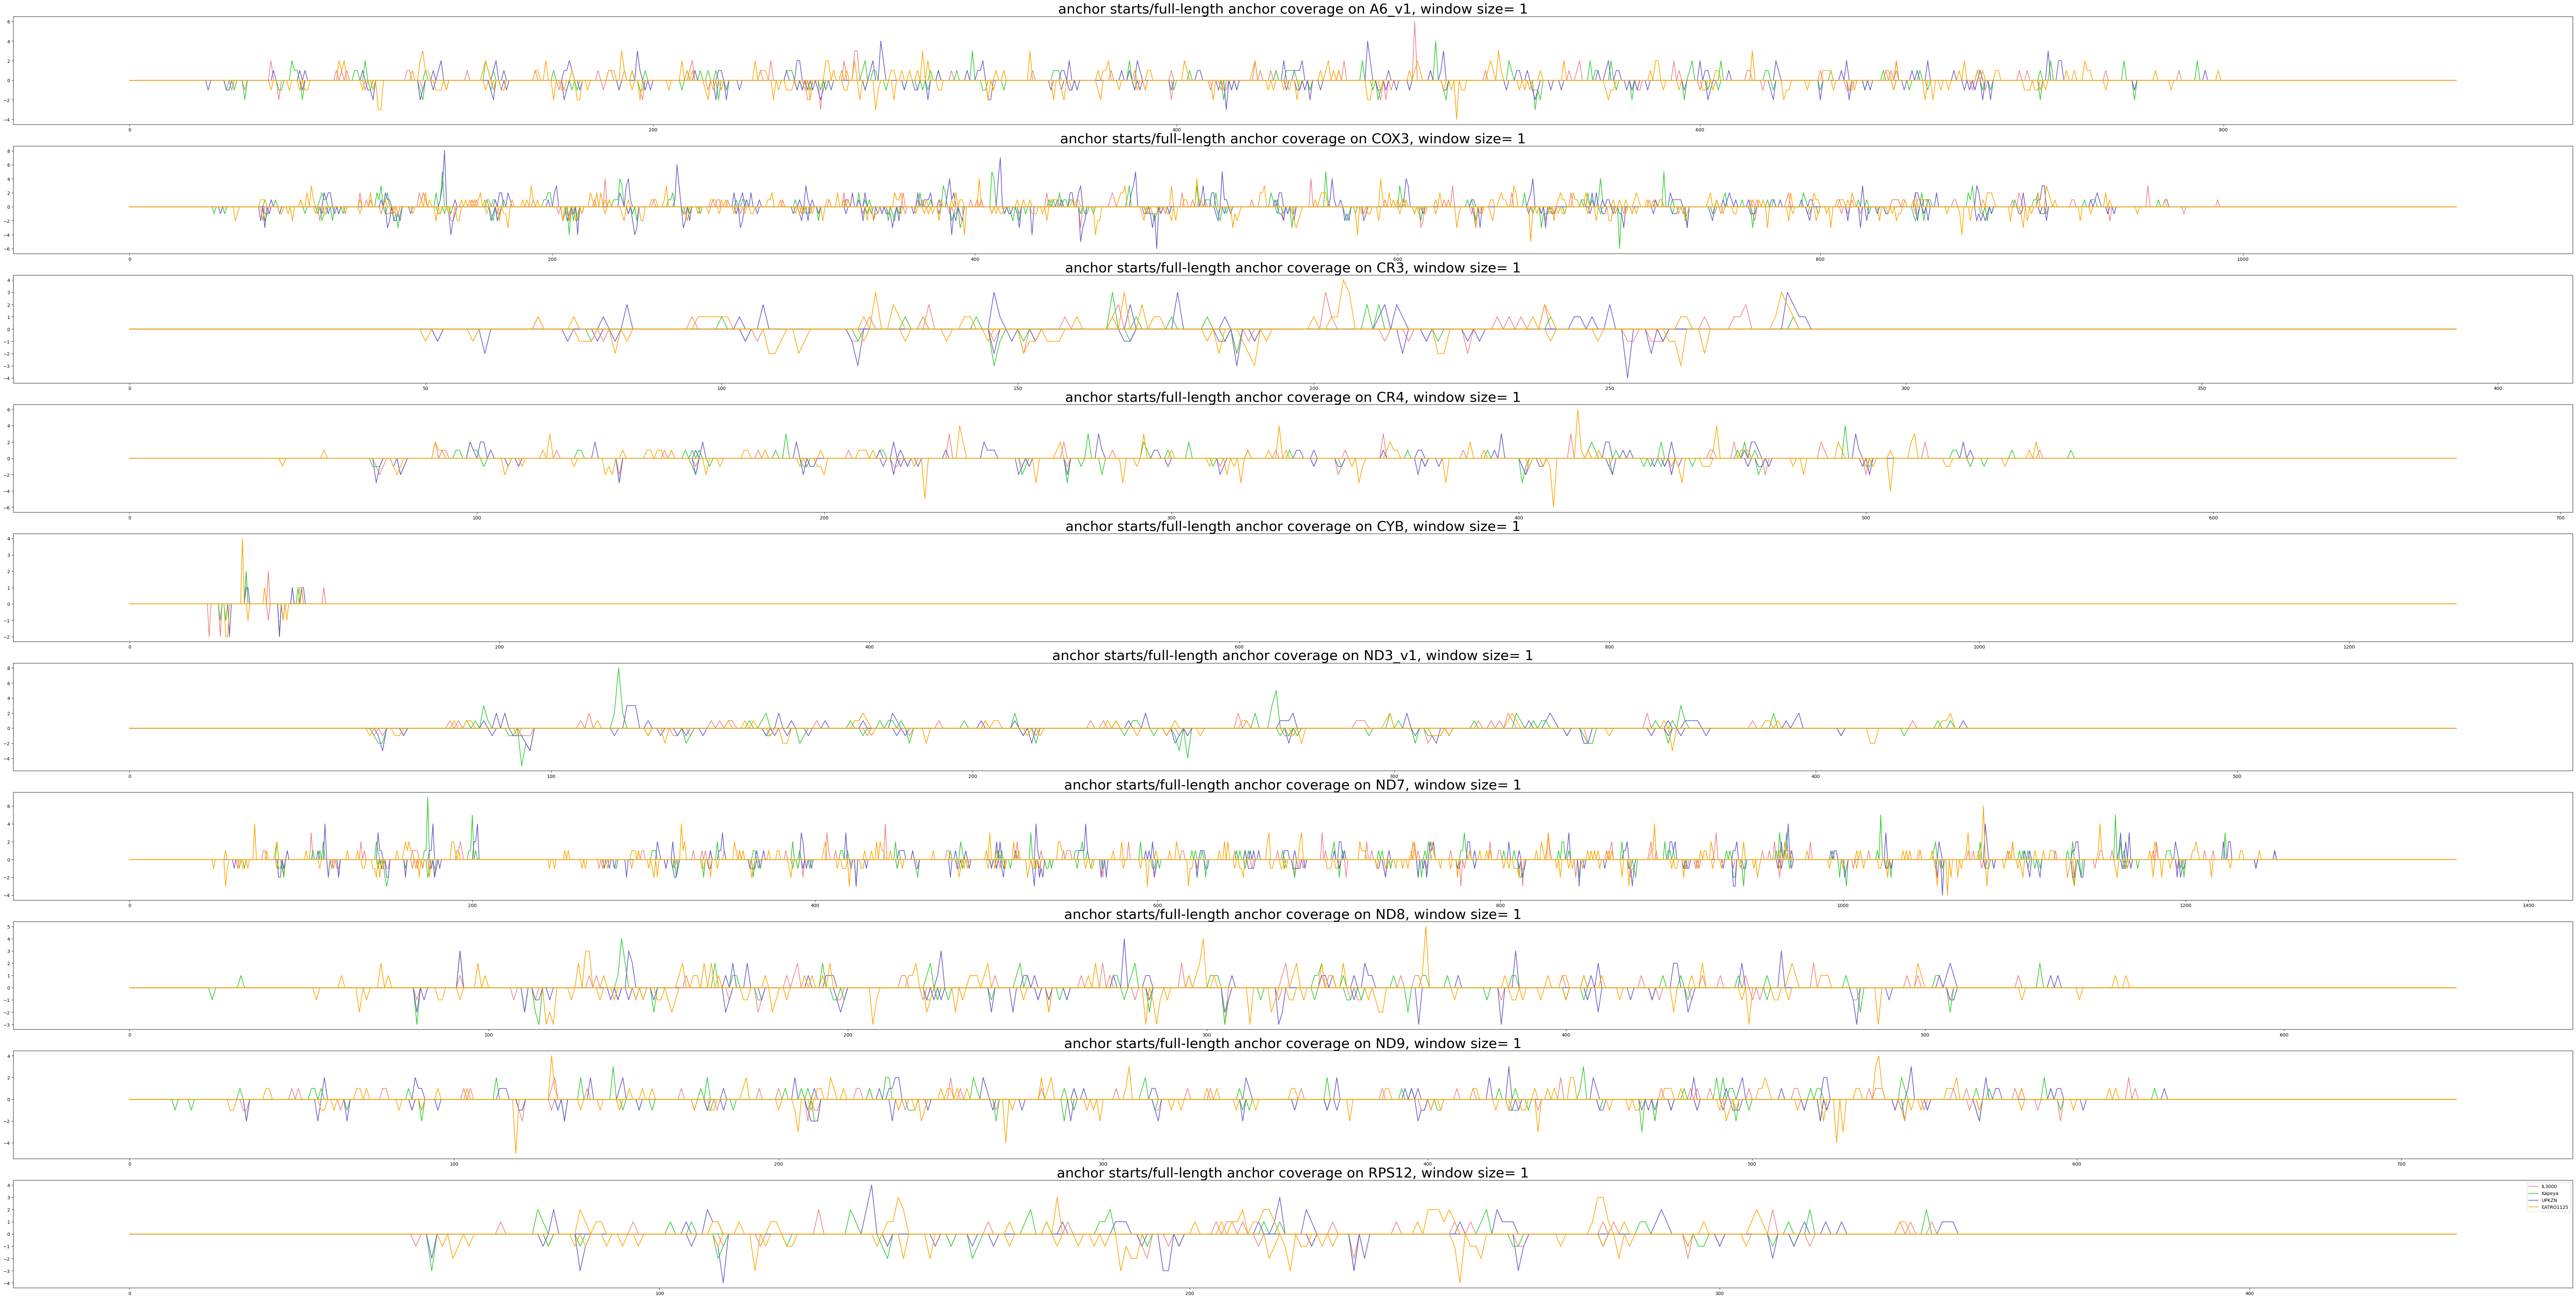

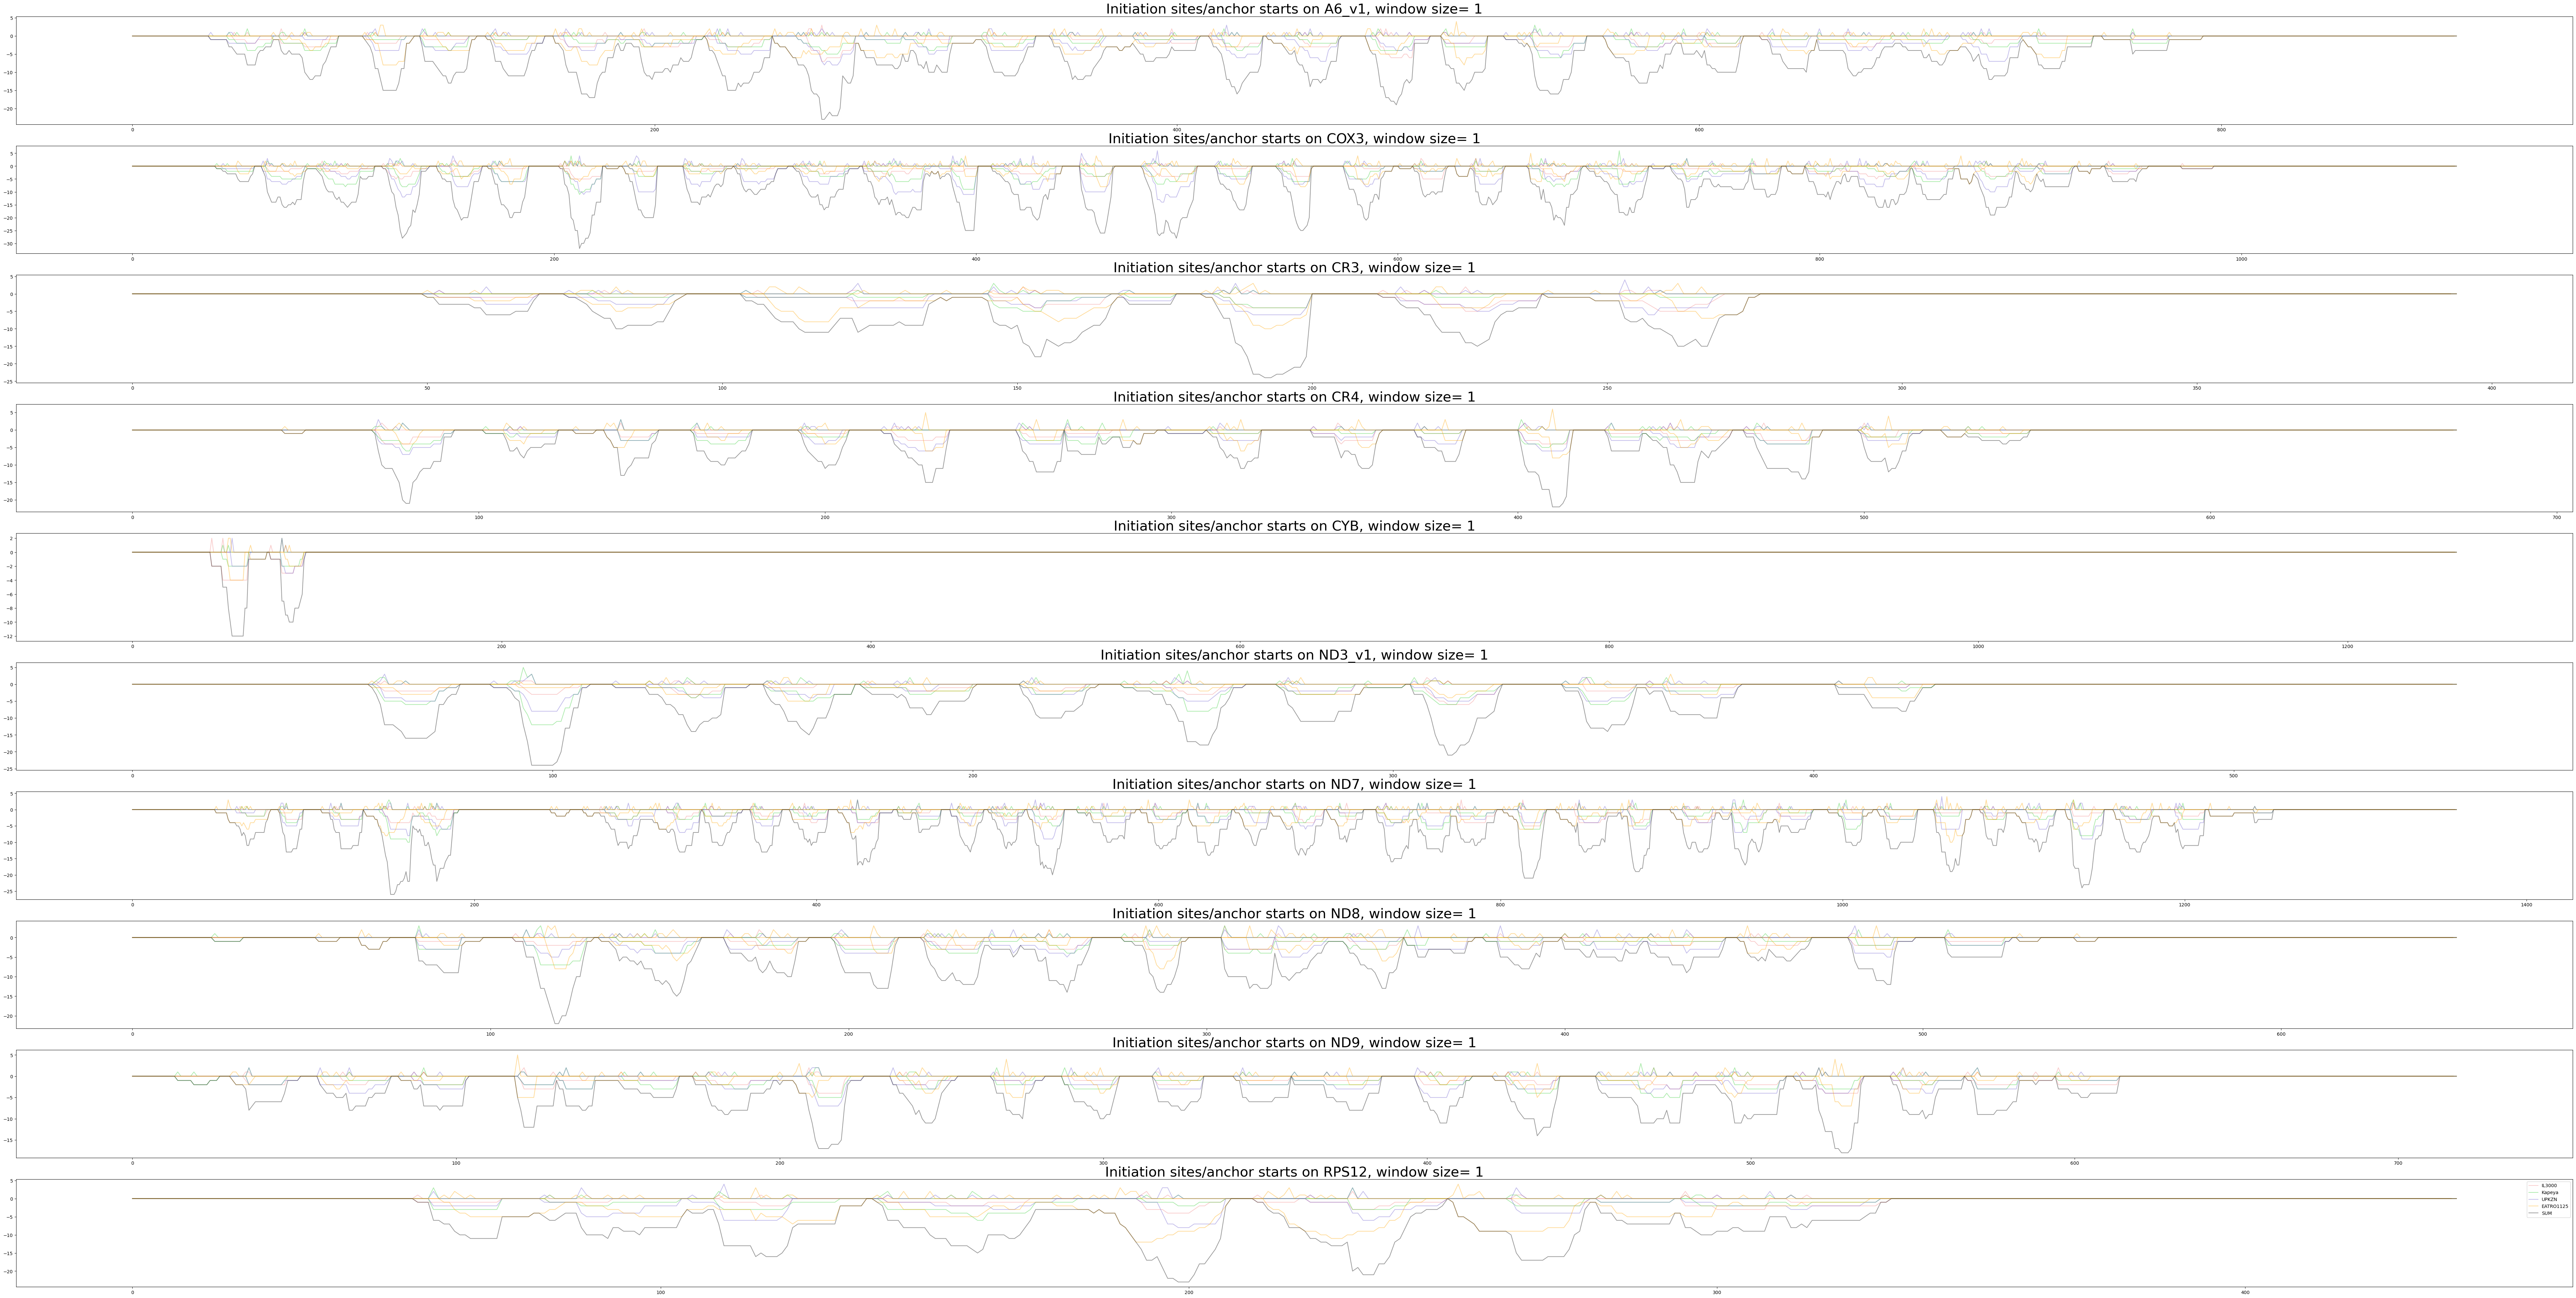

In [10]:
file1=f'{outdir}/compare_anchor_init_{strain}.pdf'
file2=f'{outdir}/overlapping_anchors_{strain}.pdf'
sum_anchor=slide_window_plot_by_strain(strain_grna,small_u,insertions,file1,file2,ws=1,figw=100,figh=50)

In [11]:
#make gRNA_family with anchor
gRNA_families=anchor_clusters(sum_anchor)
#gRNA_families #show gfam prior to subdivisions

identified 197 anchor clusters


In [12]:
gRNA_families=anchor_clusters(sum_anchor) #make them again
gRNA_families.pop('A6_v2')
gRNA_families.pop('ND3_v2')
#use the coverage plot to direct subdivision of 9 clusters
subdivision(gRNA_families,'A6_v1','A6_v1-30_79',['1111111334555588885443331','4554555569999999875333'])
subdivision(gRNA_families,'A6_v1','A6_v1-162_219',['2234899999999999999966632442','333799999999999888677763111'])
subdivision(gRNA_families,'A6_v1','A6_v1-246_346',['2233345668889999999999999999999','4466668888888998577','58897999899995222222222','23689999999999875333'])
subdivision(gRNA_families,'A6_v1','A6_v1-352_409',['1333577999999999987643333344333','3455777766666534444444441'])
subdivision(gRNA_families,'A6_v1','A6_v1-564_617',['13456666779999999999989555322','55555456488999999999972'])
subdivision(gRNA_families,'A6_v1','A6_v1-624_751',
            ['111255557899999999544','444444444459999999999866433332','33444444665777887544443','457658999999999966662','23345889999999773333333333'])
subdivision(gRNA_families,'COX3','COX3-62_115',['24999999999999999996211111','234799999999999999994555444'])
subdivision(gRNA_families,'COX3','COX3-347_401',['33668999999999999999999999996334','2332544334899999999999'])
subdivision(gRNA_families,'COX3','COX3-730_782',['23455699999998855557887888888999999761','69999999999994'])
subdivision(gRNA_families,'COX3','COX3-794_921',
            ['3666899999999866743664444','888999999999999999999997','114777999999999999555111','555576345899999999999999972','367799996356588888888888851'])
subdivision(gRNA_families,'CR3','CR3-104_177',
            ['22335788899999997779999999899993212111111','289999999999999999997311','33333333'])
subdivision(gRNA_families,'CR4','CR4-426_462',['266666666611','233455999999999678665432'])
subdivision(gRNA_families,'ND3_v1','ND3_v1-341_383',['222259999999999961','3222588999999999944441'])
subdivision(gRNA_families,'ND7','ND7-136_191',['1222223356899999999999999999','66768899999999999999998111'])
subdivision(gRNA_families,'ND7','ND7-264_333',['11222211112224456669999999999888633333333','4446666677667999999999977771'])
subdivision(gRNA_families,'ND7','ND7-645_697',['11123566789999766664','1222223456665799999999999955554'])
subdivision(gRNA_families,'ND7','ND7-728_798',['3444699999999999999553','767889999999999988822','67999999999999999444441'])
subdivision(gRNA_families,'ND7','ND7-833_889',['113333344557499999999999999994222222','322279999999999994'])
subdivision(gRNA_families,'ND7','ND7-900_983',
            ['112333379999999999999998331','2333321799999999999999999664444','475555567777766664331'])
subdivision(gRNA_families,'ND7','ND7-1081_1125',['1148999999666751111','22344479999999999975552'])
subdivision(gRNA_families,'ND7','ND7-1159_1212',['1333579999999999999986322','44444555476999999999999888'])
subdivision(gRNA_families,'ND8','ND8-221_268',['1578999999999999522333333542','3333665999999997753'])
subdivision(gRNA_families,'ND8','ND8-305_355',['899999999999994','8999999886544211111','2445778899999984'])
subdivision(gRNA_families,'ND8','ND8-400_445',['333334553555555663444211','445555777798555555553'])
subdivision(gRNA_families,'ND9','ND9-453_511',['3445555555567999999998999944442222222','344569999999999999933'])
subdivision(gRNA_families,'RPS12','RPS12-54_139',['111667799999999955555544','566544489999988999988888885344433','7999999999999987777777722222'])
subdivision(gRNA_families,'RPS12','RPS12-141_208',['1266688888999999999999999999863333333','333343444789999999999999999992'])
subdivision(gRNA_families,'RPS12','RPS12-250_333',['1556799999999999999999999311','4446677777777744','88999999988999995555','8878666666666654411'])
#sort again at the end
gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
total=sum([len(v) for v in gRNA_families.values()])
print(f"identified {total} anchor clusters")

identified 197 anchor clusters
{'bound': (30, 55), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '1111111334555588885443331'}
{'bound': (57, 79), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '4554555569999999875333'}
{'bound': (162, 190), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '2234899999999999999966632442'}
{'bound': (192, 219), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '333799999999999888677763111'}
{'bound': (246, 277), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '2233345668889999999999999999999'}
{'bound': (279, 298), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '4466668888888998577'}
{'bound': (300, 323), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '58897999899995222222222'}
{'bound': (326, 346), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '23689999999999875333'}
{'bound': (352, 383), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '1333577999999999987643333344333'}
{'bound': (384, 409), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '3455777766666534444444441'}
{'bound': (564, 593), 'gRNA': [], 'mRNA': 'A6_v1', '

In [13]:
def isolate_mRNA_gfam(gRNA_family,gRNA_dict,csv_out):
    strains=['IL3000','Kapeya','UPKZN','EATRO1125']
    strain_gfam={}
    for k in gRNA_family:
        strain_gfam[k]={}
        for s in strains:
            strain_gfam[k][s]=len([gf for gf,v in gRNA_family[k].items() if s in [g.split('_')[0] for g in v['gRNA']]])
    df=pd.DataFrame.from_dict(strain_gfam,orient='index')
    df.to_csv(csv_out)

strain_gfam=isolate_mRNA_gfam(gRNA_families,gRNA_dict,f'{outdir}/gRNA_fam_per_mRNA.csv')      

In [14]:
#update family info and gRNA info
gRNA_dict,gRNA_families=assign_gRNA_families_anchor(gRNA_dict,gRNA_families)
check_gRNA_number(gRNA_dict,gRNA_families)
#remove records on certain mRNAs
gRNA_families={k:v for k,v in gRNA_families.items() if k in to_plot}
check_gRNA_number(gRNA_dict,gRNA_families)
for g in gRNA_dict:
    gRNA_dict[g]['gRNA']=g
gf_presence={}
for k in gRNA_families:
    for gf in gRNA_families[k]:
        gf_presence[gf]=round(len(set([i.split('_')[0] for i in gRNA_families[k][gf]['gRNA']]))/3,2) 

number of gRNA in gRNA family dict: 2933 
number of gRNA in gRNA dict:2935
number of gRNA in gRNA family dict: 2933 
number of gRNA in gRNA dict:2935


In [15]:
filename=f'{outdir}/gRNA_combined_visual_{strain}.pdf'
init_grna_comb(sum_anchor,gRNA_families,gRNA_dict,gf_presence,filename,figw=100,figh=100,color_by_subspecies=False)

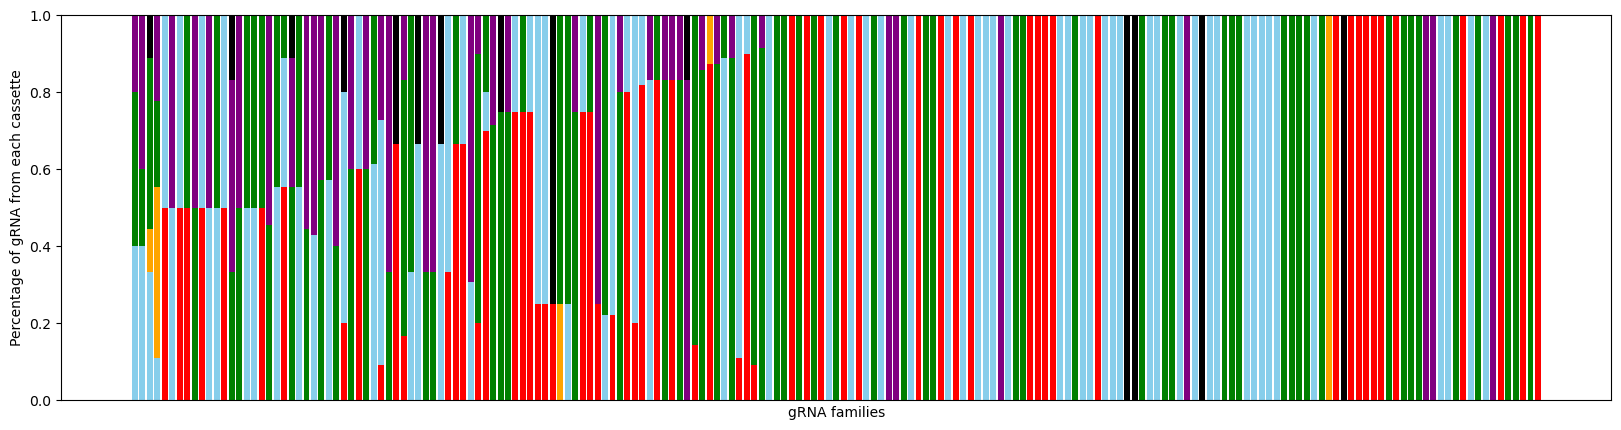

76 gRNA families were dominant by gRNAs from cassette IV or V
178 gfam were shared by Tc and Tc, 24 have the same dominant cassette
185/189 gRNA families contained over 50.0% gRNAs from one cassette
162/189 gRNA families contained over 60.0% gRNAs from one cassette
143/189 gRNA families contained over 70.0% gRNAs from one cassette
124/189 gRNA families contained over 80.0% gRNAs from one cassette
107/189 gRNA families contained over 90.0% gRNAs from one cassette
104/189 gRNA families contained over 100% gRNAs from one cassette
16 gRNAs were found in 1 isolates
['COX3-225_231', 'COX3-601_607', 'COX3-721_727', 'COX3-785_793', 'COX3-923_934', 'COX3-972_987', 'CR4-44_50', 'CR4-128_134', 'CR4-299_310', 'ND7-245_256', 'ND8-23_31', 'ND8-52_58', 'ND8-64_72', 'ND8-527_533', 'ND8-543_549', 'ND9-14_27']
{'COX3-225_231': ['30'], 'COX3-601_607': ['40'], 'COX3-721_727': ['27'], 'COX3-785_793': ['40', '40', '45'], 'COX3-923_934': ['43', '41', '38'], 'COX3-972_987': ['49'], 'CR4-44_50': ['40'], 'CR4-1

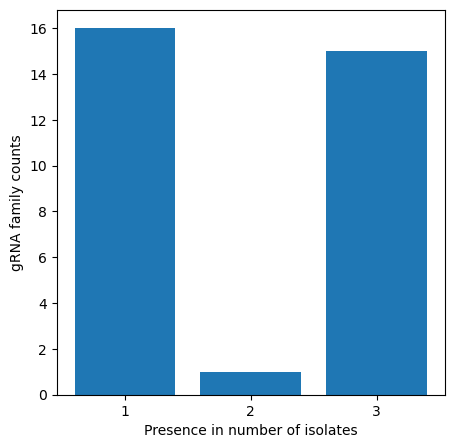

In [16]:
#only look at EATRO1125
def cassette_distribution(gRNA_families,gRNA_dict,figw=20,figh=5):
    cs,isocounts=['I','II','III','Orphan','IV','V'],[1,2,3,4,5]
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
    cass={gf:[gRNA_dict[g]['cassette_label'] for g in v['gRNA'] if 'EATRO1125' in g] for gf,v in gfam.items()}
    cass={gf: {c: v.count(c)/len(v) for c in cs} for gf,v in cass.items() if len(v) !=0}
    #Tc gfam info
    tccass={gf:[gRNA_dict[g]['cassette_label'] for g in v['gRNA'] 
                if 'IL3000' in g or 'Kapeya' in g or 'UPKZN' in g] for gf,v in gfam.items()}
    tccass={gf: {c: v.count(c)/len(v) for c in cs} for gf,v in tccass.items() if len(v) !=0}
    tccass={k:v for k,v in sorted(tccass.items(), key=lambda item: max(item[1].values()))}
    #sort and put the gRNAs with the least conserved cassettes first
    cass={k:v for k,v in sorted(cass.items(), key=lambda item: max(item[1].values()))}
    df=pd.DataFrame.from_dict(cass, orient='index')
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    ax.bar(df.index, (df['I']), label='I',color='r')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='skyblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='orange')
    ax.bar(df.index, (df['IV']),bottom=(df['I']+df['II']+df['III']),label='III',color='green')
    ax.bar(df.index, (df['V']),bottom=(df['I']+df['II']+df['III']+df['IV']),label='III',color='purple')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']+df['IV']+df['V']),label='Orphan',color='black')
    ax.set_xticks([])
    ax.set_xlabel('gRNA families')
    ax.set_ylabel('Percentage of gRNA from each cassette')
    plt.show()
    #some statistics
    casmax={k:max(v.values()) for k,v in cass.items()}
    dominantcas={k:max(v, key=v.get) for k,v in cass.items()}
    #tc
    tccasmax={k:max(v.values()) for k,v in tccass.items()}
    tcdominantcas={k:max(v, key=v.get) for k,v in tccass.items()}
    #
    print(f"{len([v for v in dominantcas.values() if v in ['IV','V']])} gRNA families were dominant by gRNAs from cassette IV or V")
    #if the dominant cassette is the same between shared gfam:
    gfamshared=[k for k in casmax if k in tccasmax]
    gfamshared_same_cassette=[k for k in casmax if k in tccasmax and dominantcas[k]==tcdominantcas[k]]
    print(f"{len(gfamshared)} gfam were shared by Tc and Tc, {len(gfamshared_same_cassette)} have the same dominant cassette")
    #all in one cassette
    for cut in [0.5,0.6,0.7,0.8,0.9, 1]:
        s1=[k for k,v in casmax.items() if v>=cut]
        print(f"{len(s1)}/{len(casmax)} gRNA families contained over {cut*100}% gRNAs from one cassette")
    #isolates
    iso={gf: set([g.split('_')[0] for g in v['gRNA']]) for gf,v in gfam.items()}
    data={k:len(v) for k,v in iso.items()}
    for i in isocounts:
        s=list(data.values()).count(i)
        print(f"{s} gRNAs were found in {i} isolates")
        if i==1:
            a=[k for k,v in data.items() if v==1]
            print(a)
            a={gf: [gRNA_dict[g]['length'] for g in gfam[gf]['gRNA']] for gf in a }
            print(a)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x=[1,2,3]
    ax.bar(x,[list(data.values()).count(i) for i in x])
    ax.set_xticks(x)
    ax.set_xlabel('Presence in number of isolates')
    ax.set_ylabel('gRNA family counts')
    plt.show()
    return(df)

cass=cassette_distribution(gRNA_families,gRNA_dict)

In [17]:
104/189

0.5502645502645502

In [23]:
#editing block analysis
def editing_block(gRNA_families,gRNA_dict,anchorlen=6,figw=20,figh=5):
    cs,isocounts,isolates=['I','II','III','Orphan'],[1,2,3],['IL3000','Kapeya','UPKZN','EATRO1125']
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
    ed_blocks={gf:{s:(min([gRNA_dict[g]['mRNA_start'] for g in v['gRNA'] if s in g]),max([gRNA_dict[g]['mRNA_end']-anchorlen for g in v['gRNA'] if s in g])) 
                   for s in isolates if s in [i.split('_')[0] for i in v['gRNA']]} 
               for gf,v in gfam.items()}
    startsdiff={gf: max([abs(pair[0]-pair[1]) for pair in combinations([pos[0] for pos in d.values()],2)]) for gf,d in ed_blocks.items() if len(d)>1 }
    endsdiff={gf: max([abs(pair[0]-pair[1]) for pair in combinations([pos[1] for pos in d.values()],2)]) for gf,d in ed_blocks.items() if len(d)>1 }
    data=[list(startsdiff.values()),list(endsdiff.values())]
    labels=['start difference','end difference']
    #basic stats
    for label,d in zip(labels,data):
        print(label)
        mean=round(sum(d)/len(d),2)
        med=statistics.median(d)
        mod=statistics.mode(d)
        print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=False)
    ax = sns.violinplot(data, inner=None,cut=0,orient='h')
    ax=sns.stripplot(data, edgecolor='black', linewidth=1, palette=['white']*len(data) ,orient='h') 
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'Difference (nt)')
    #
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'Difference (nt)',fontsize=20)
    plt.show()
    return(ed_blocks)
def plot_editng_blocks(ed_blocks_by_mrna,filename,exception,figw=100,figh=50,floor=-20,shared_only=False):
    taxon_dict={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue','EATRO1125':'orange'}
    shape_dict={'IL3000':'o','Kapeya':'v','UPKZN':'s','EATRO1125':'d'} #circle,triangle,square
    add_dict={'IL3000':0,'Kapeya':-2,'UPKZN':-4,'EATRO1125':-6} #circle,triangle,square
    c,c_dict=0,{'I':'r','II':'skyblue','III':'orange','Orphan':'black'}
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len([k for k in ed_blocks_by_mrna if 'v2' not in k]),1,figsize=(figw,figh))
    for k,v in ed_blocks_by_mrna.items():
        if 'v2' not in k:
            ax,d=axs[c],0
            ax.set_title(f'Editing blocks on {k} (nt)',fontdict={'fontsize': 30, 'fontweight': 30})
            c+=1
            #plot init sites
            #ax.plot(range(len(counts[k])),counts[k],label=k)
            ax.set_xlim(left=0,right=len(insertions[k])+60)
            #plot boundaries
            #draw insertion sites: 0 for insertions
            x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
            y=[d]*len(x)
            ax.scatter(x,y,marker=3,color='purple',linewidth=5)
            d+=-1
            #draw deletions
            x=[i for i,c in enumerate(dels[k]) if c==0 ] 
            y=[d]*len(x)
            ax.scatter(x,y,marker=3,color='red',linewidth=5)
            d+=-1
            #draw gRNA families
            ceiling=d
            if shared_only==False:
                tmp=ed_blocks_by_mrna[k]
            else: #include only gf in all three isolates
                tmp={gf:v for gf,v in ed_blocks_by_mrna[k].items() if len(v)>=3 or gf in exception}
            for i,gf in enumerate(tmp):
                if i%2==1:
                    d=-4 #alternate starting height
                else:
                    d=-14
                ax.text(max([i[1] for i in ed_blocks_by_mrna[k][gf].values()]),d,f"{gf}")
                for s,bound in ed_blocks_by_mrna[k][gf].items():
                    ax.add_patch(Rectangle((bound[0], d+add_dict[s]), bound[1]-bound[0], -1,
                                  facecolor = taxon_dict[s],alpha=0.6)) #coding region
    plt.savefig(filename)
    plt.show()

def length_of_ed_block_stats(ed_blocks_by_mrna):
    data=[[b[1]-b[0] for gf in v for b in v[gf].values()] for k,v in ed_blocks_by_mrna.items()]
    summary={}
    #basic stats
    for label,d in zip(ed_blocks_by_mrna.keys(),data):
        mean=round(sum(d)/len(d),2)
        med=statistics.median(d)
        mod=statistics.mode(d)
        summary[label]={'mean':mean,'median':med,'mode':mod,'max':max(d),'min':min(d)}
        #print(f"{label} mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
    df=pd.DataFrame.from_dict(summary,orient='index')
    print(df)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=ed_blocks_by_mrna.keys(),vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(ed_blocks_by_mrna.keys(),style='italic')
    ax.set_xlabel(f'Length of effective editing range of gRNA families')
    plt.show()
    return(df)
#
def calculate_interval(ed_blocks_by_mrna,exception,shared_only=False):
    isolates=['IL3000','Kapeya','UPKZN','EATRO1125']
    summary={k:{} for k in ed_blocks_by_mrna}
    for k in ed_blocks_by_mrna:
        if shared_only==False:
            tmp=ed_blocks_by_mrna[k]
        else: #include only gf in all three isolates
            tmp={gf:v for gf,v in ed_blocks_by_mrna[k].items() if len(v)>=3 or gf in exception}
        for s in isolates:
            starts=[v[s][0] for gf,v in tmp.items() if s in v]
            ends=[v[s][1] for gf,v in tmp.items() if s in v]
            d1=[starts[i+1]-n for i,n in enumerate(starts[:-1])]
            d2=[ends[i+1]-n for i,n in enumerate(ends[:-1])]
            mean=round(sum(d1)/len(d1),2)
            med=statistics.median(d1)
            mod=statistics.mode(d1)
            if len(d1)>2:
                sd=round(statistics.stdev(d1),2)
            else:
                sd=np.nan
            #sts={'mean':mean,'median':med,'mode':mod,'max':max(d1),'min':min(d1)}
            sts=(mean,sd)
            summary[k][s]=sts#
    df=pd.DataFrame.from_dict(summary,orient='index')
    return(df)
            


start difference
mean: 7.34, median: 6, mode: 4, max: 27, min: 0
end difference
mean: 5.59, median: 5, mode: 1, max: 18, min: 0


/tmp/ipykernel_4802/2508143479.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels,style='italic')


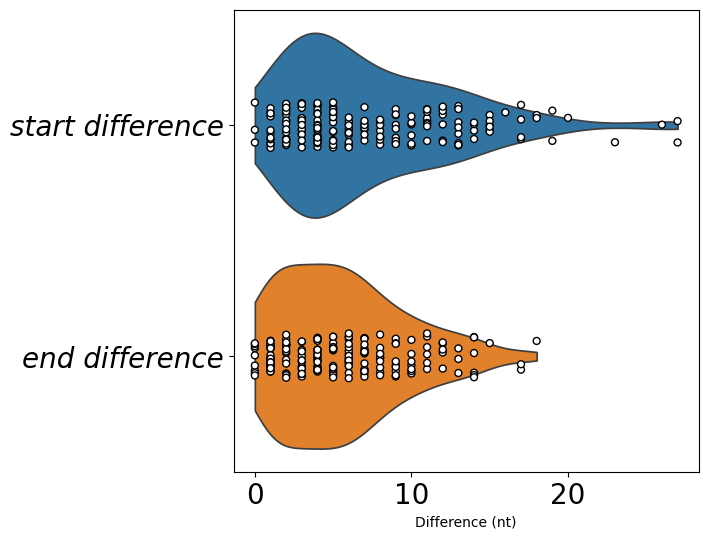

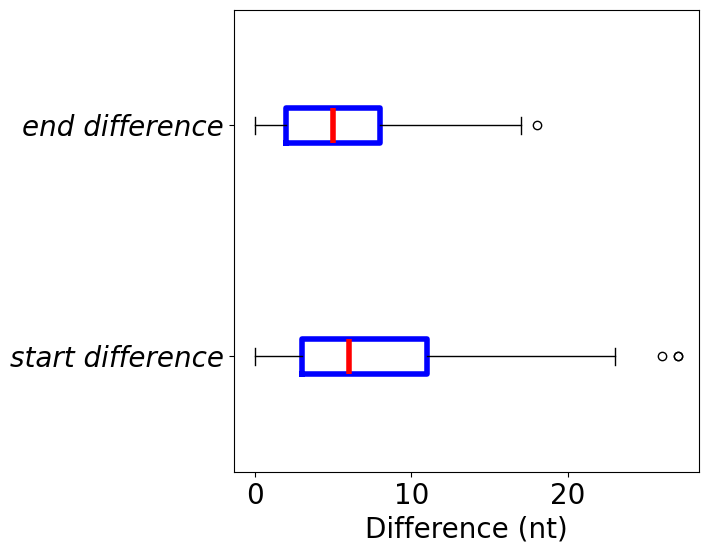

In [24]:
ed_blocks=editing_block(gRNA_families,gRNA_dict,anchorlen=6,figw=20,figh=5)
ed_blocks_by_mrna={k:{gf:v for gf,v in ed_blocks.items() if k in gf} for k in gRNA_families}
exception=[]

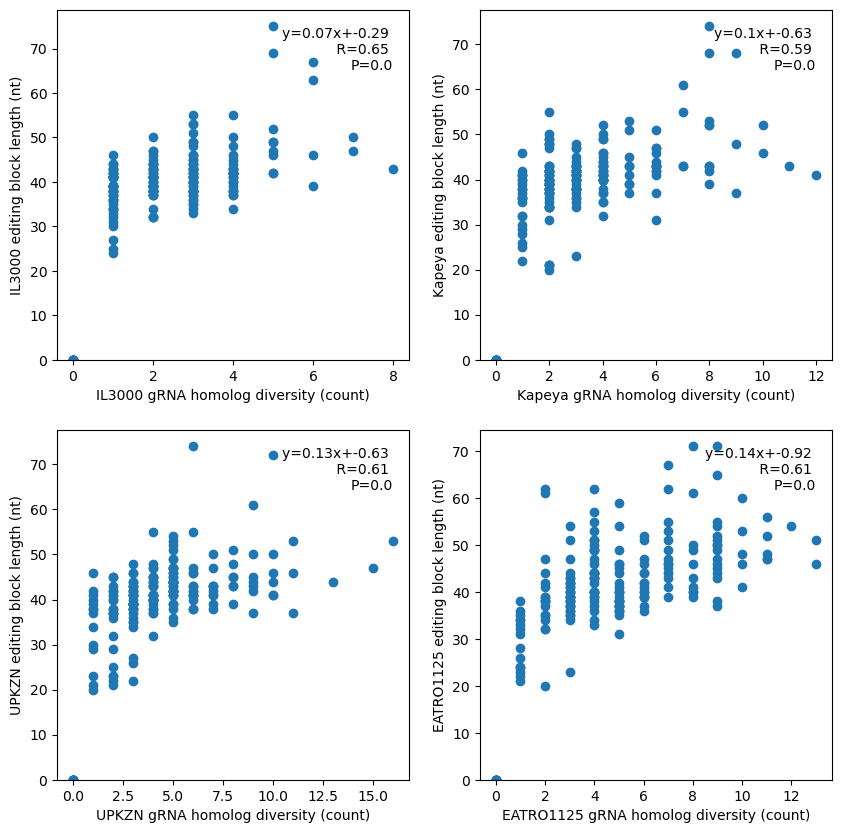

In [20]:
def length_correlation_ed_blocks(gfam,ed_blocks):
    isolates=['IL3000','Kapeya','UPKZN','EATRO1125']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
    for i,s in enumerate(isolates):
        ax=axs[int(i/2),i%2]
        x=[ed_blocks[gf].get(s,(0,0))[1]-ed_blocks[gf].get(s,(0,0))[0] for gf, v in gfam.items()]
        y=[len([g for g in gfam[gf]['gRNA'] if s in g]) for gf, v in gfam.items()]
        corr=linregress(x, y)
        ax.scatter(y,x)
        ax.set_ylim(bottom=0)
        ax.set_ylabel(f"{s} editing block length (nt)")
        ax.set_xlabel(f"{s} gRNA homolog diversity (count)")
        ax.text(max(y),max(x),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \nP={round(corr.pvalue,5)}",ha='right',va='top')
    plt.show()
            
gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
length_correlation_ed_blocks(gfam,ed_blocks)

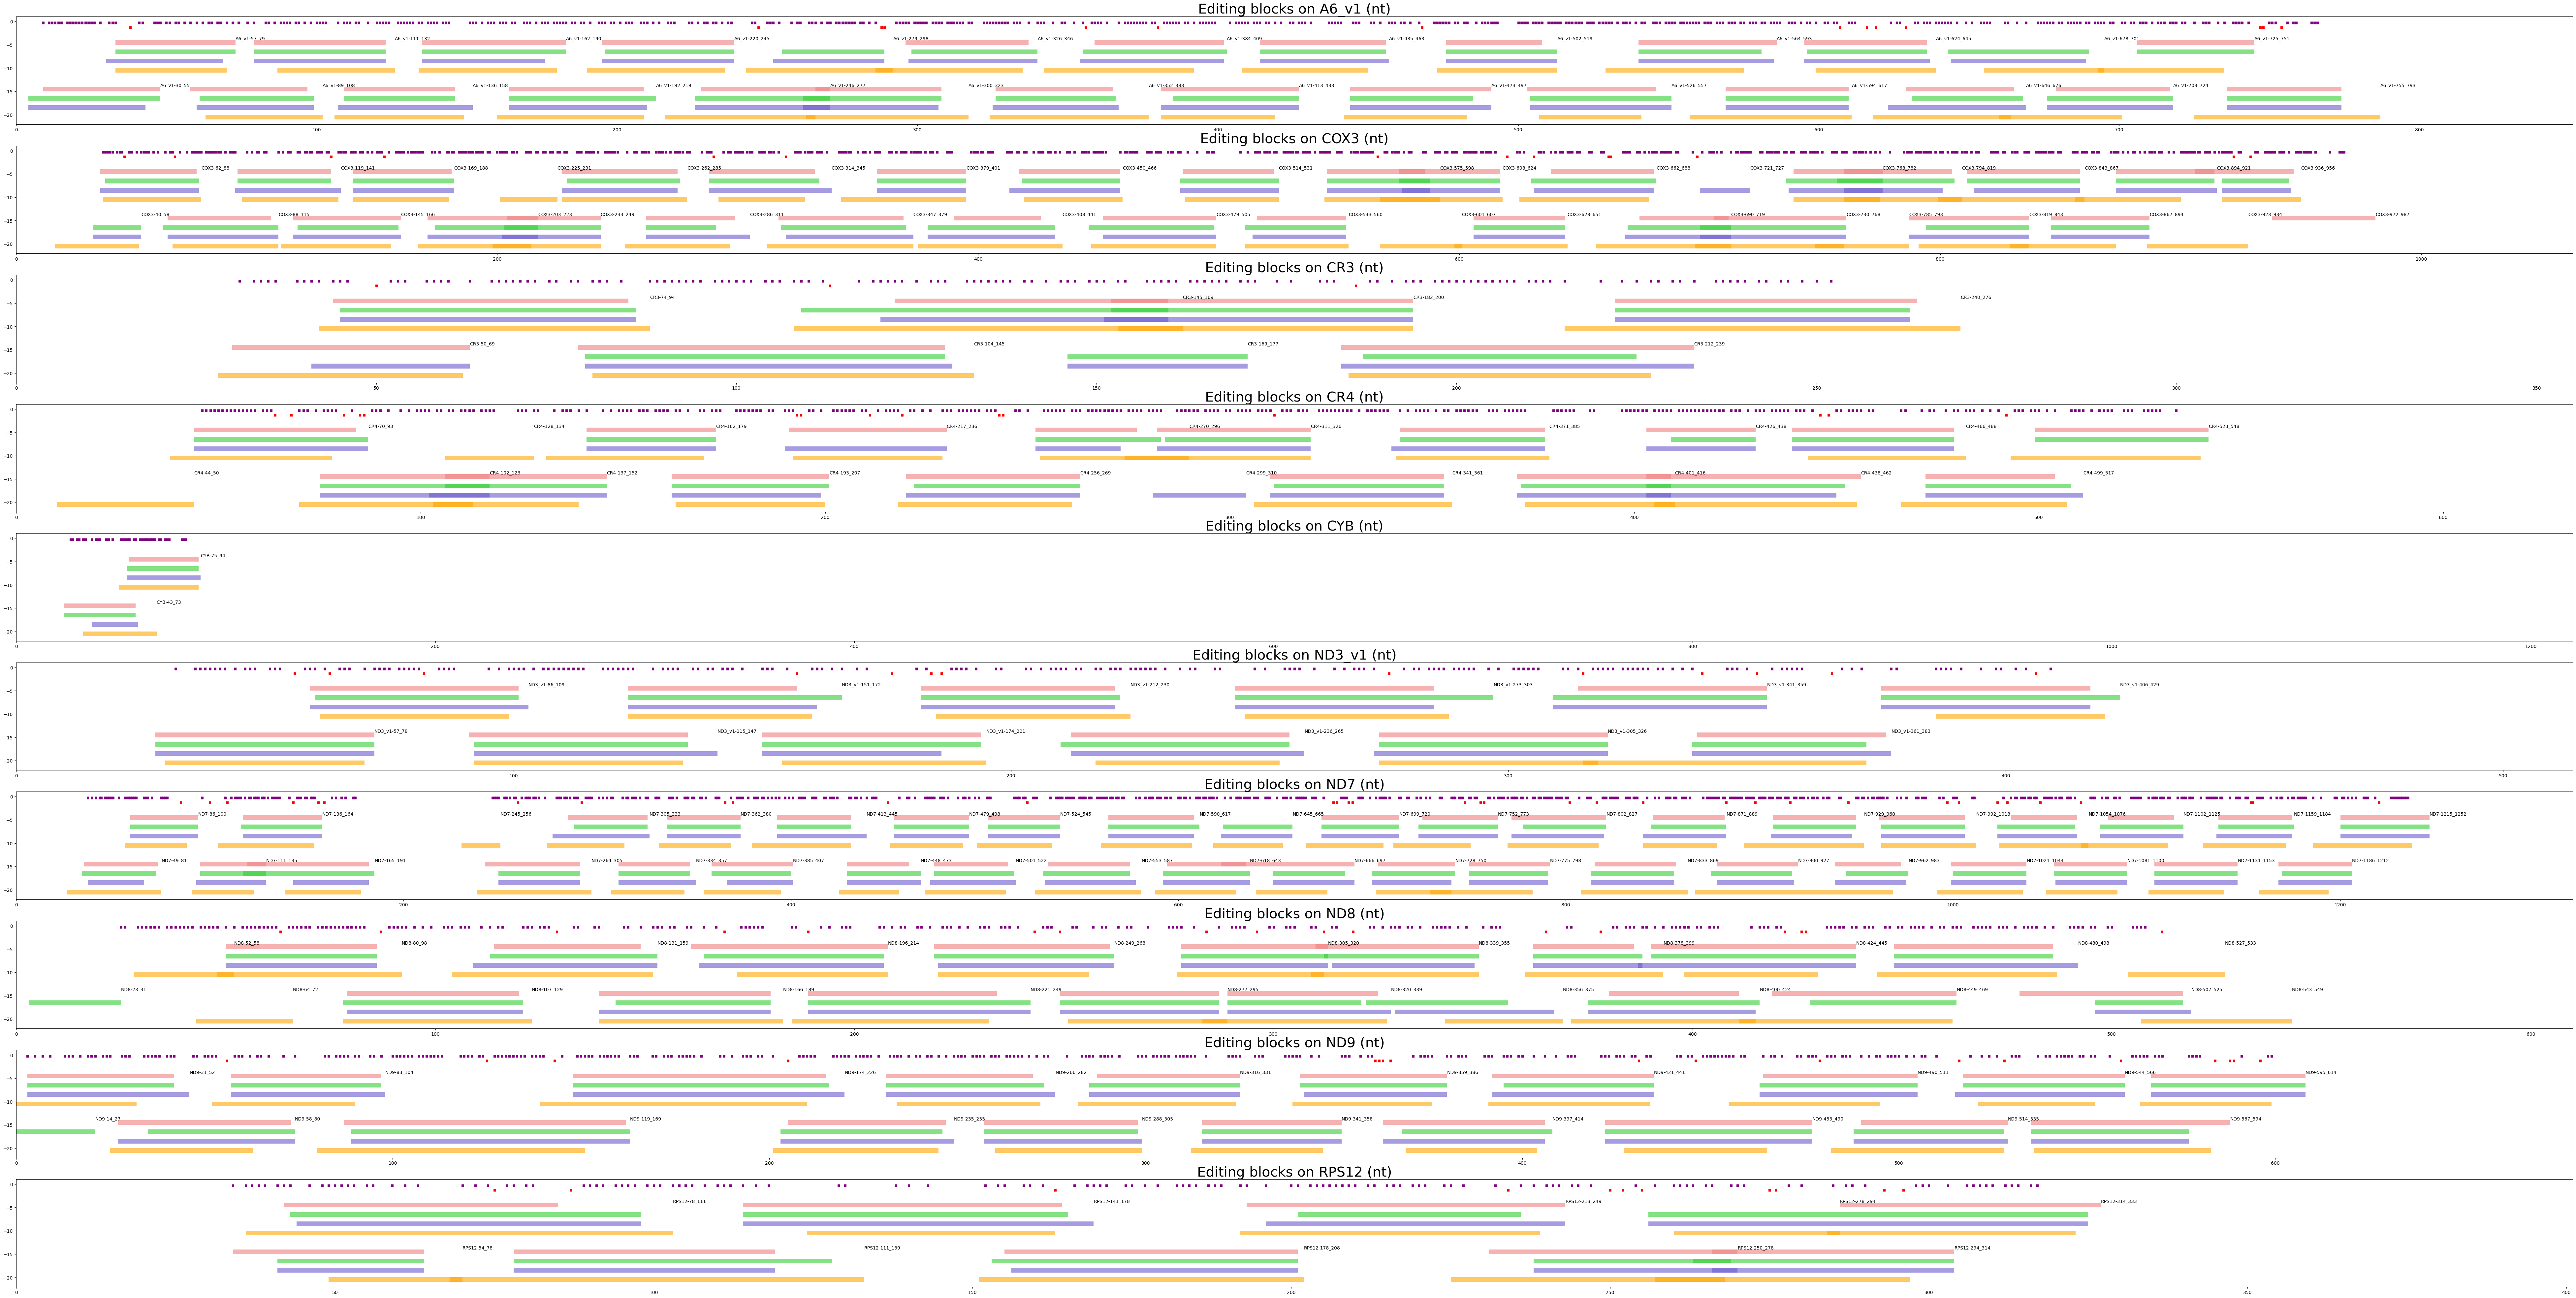

In [21]:
outfile=f"{outdir}/Effective_editing_range.pdf"
plot_editng_blocks(ed_blocks_by_mrna,outfile,exception,figw=100,figh=50,floor=-20,shared_only=False)

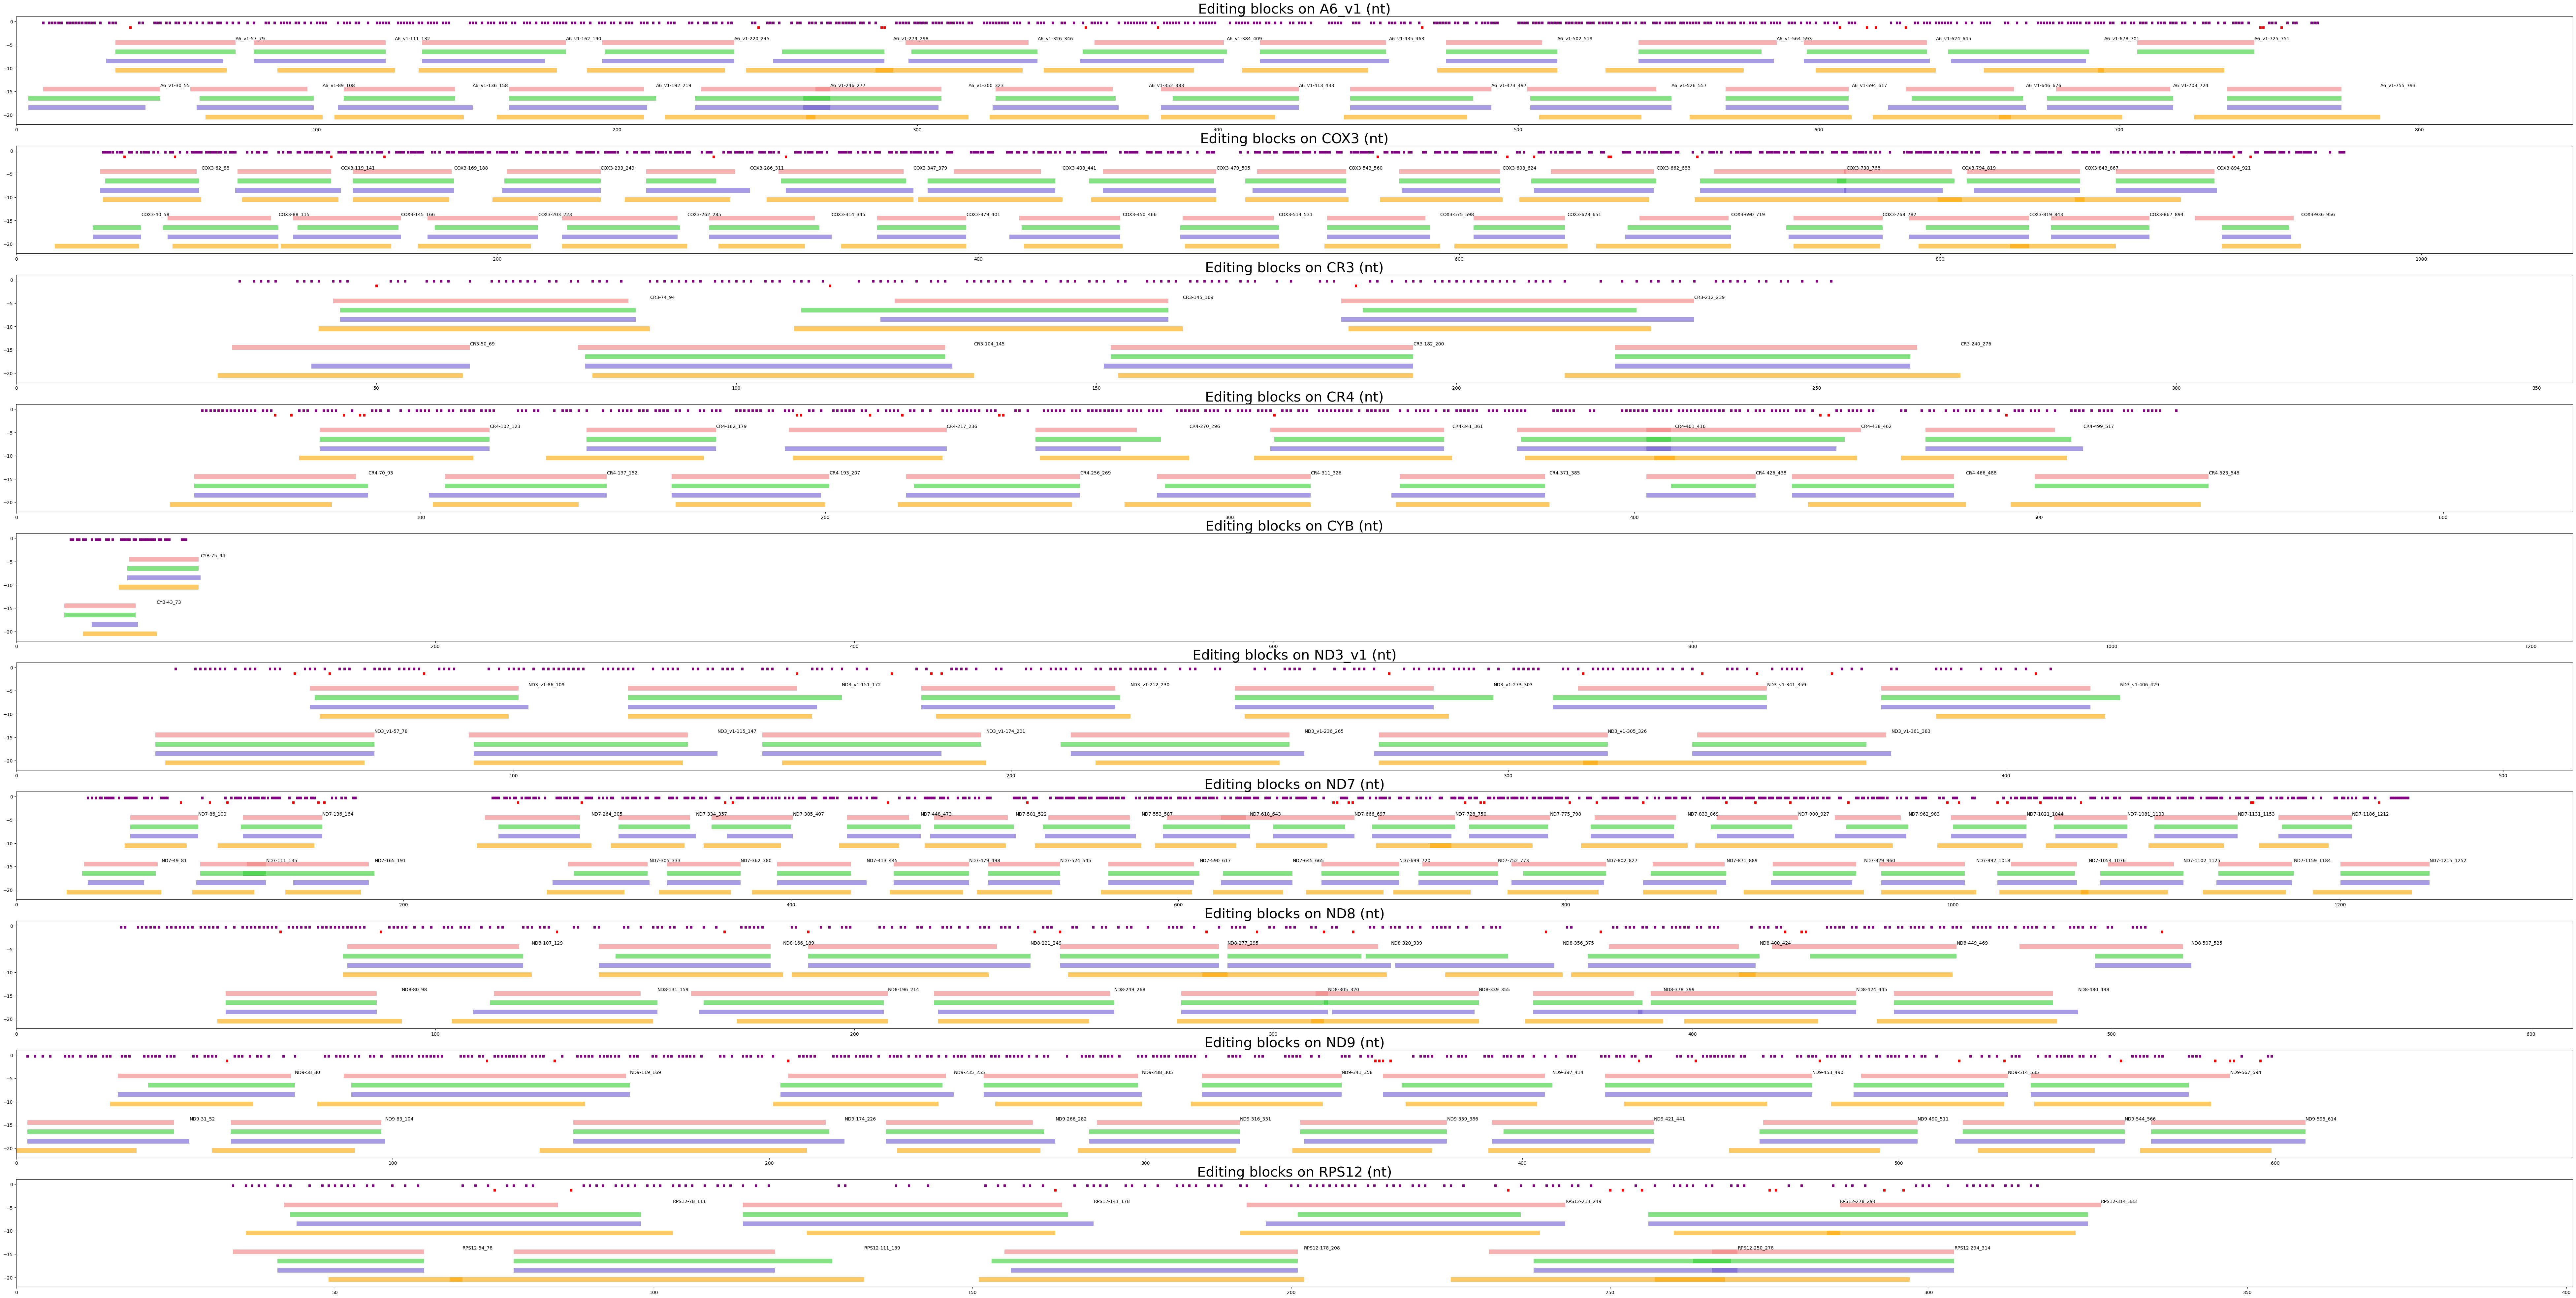

In [22]:
outfile=f"{outdir}/Effective_editing_range_shared_only.pdf"
plot_editng_blocks(ed_blocks_by_mrna,outfile,exception,figw=100,figh=50,floor=-20,shared_only=True)

In [23]:
#no graph, just csv output to make a table
df=calculate_interval(ed_blocks_by_mrna,exception,shared_only=True)
csv_out=f"{outdir}/editing_block_interval_per_isolate_per_mRNA.csv"
df.to_csv(csv_out)
print(df)

                IL3000          Kapeya           UPKZN       EATRO1125
A6_v1    (30.29, 5.96)   (28.15, 6.53)   (29.28, 8.29)   (27.68, 8.08)
COX3     (30.03, 4.56)    (29.5, 7.97)    (29.5, 7.25)   (30.03, 9.59)
CR3      (32.0, 10.12)    (35.4, 4.72)  (30.17, 13.32)  (31.17, 10.44)
CR4      (28.44, 8.33)  (30.33, 13.15)   (28.53, 8.87)   (30.33, 4.64)
CYB        (31.0, nan)     (30.0, nan)     (17.0, nan)     (17.0, nan)
ND3_v1   (31.55, 4.37)   (31.55, 3.45)   (31.55, 3.39)   (35.6, 12.94)
ND7     (31.49, 17.45)  (30.68, 18.22)  (30.61, 13.47)  (30.53, 13.74)
ND8      (26.75, 9.74)  (26.24, 10.63)  (27.88, 12.91)    (24.75, 9.4)
ND9     (31.33, 11.19)  (31.33, 10.48)  (31.33, 10.43)  (31.67, 11.76)
RPS12    (31.5, 11.41)  (27.22, 15.62)  (27.22, 14.76)  (26.11, 21.37)
